In [1]:
import sys, os, distutils.core

In [2]:
run install_detectron2.ipynb

Obtaining file:///aiffel/aiffel/aiffelthonprj/detectron2
  Preparing metadata (setup.py) ... done


  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import torch as nn

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

In [4]:
nn.cuda.empty_cache()

In [5]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

register_coco_instances('fashion_train', {}, 'Fashionpedia/instances_atrributes_train2020_new.json', 'Fashionpedia/train_img/')
register_coco_instances('fashion_val', {}, 'Fashionpedia/instances_attributes_val2020_new.json', 'Fashionpedia/test_img/')

#register_coco_instances('fashion_train_revised', {}, 'Fashionpedia/new_annotations.json', 'Fashionpedia/train_img/')
#register_coco_instances('fashion_val_revised', {}, 'Fashionpedia/new_annotations_val.json', 'Fashionpedia/test_img/')


#from detectron2.data import get_detection_dataset_dicts
#from detectron2.data.datasets import builtin_meta



In [7]:
#DatasetCatalog.register = 

In [6]:
fashion_metadata = MetadataCatalog.get("fashion_train")
dataset_dicts = DatasetCatalog.get('fashion_train')

[03/30 01:33:15 d2.data.datasets.coco]: Loading Fashionpedia/instances_atrributes_train2020_new.json takes 5.84 seconds.
[03/30 01:33:15 d2.data.datasets.coco]: Loaded 45602 images in COCO format from Fashionpedia/instances_atrributes_train2020_new.json


In [8]:
#fashion_metadata

In [9]:
# dataset_dicts[1]["file_name"]

In [10]:
# fname = 'Fashionpedia/train_img/0081580df39aa7cc74f70ede71460984.jpg'
# img = cv.imread(fname)
# img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# visualizer = Visualizer(img[:, :, ::-1], metadata=fashion_metadata, scale=1)
# #vis = visualizer.draw_dataset_dict(dataset_dicts[1])
# plt.figure(figsize=(8,8))
# plt.imshow(vis.get_image()[:, :, ::-1])

In [7]:
import random

testlist = []

for d in random.sample(dataset_dicts, 3):
    testlist.append(d)

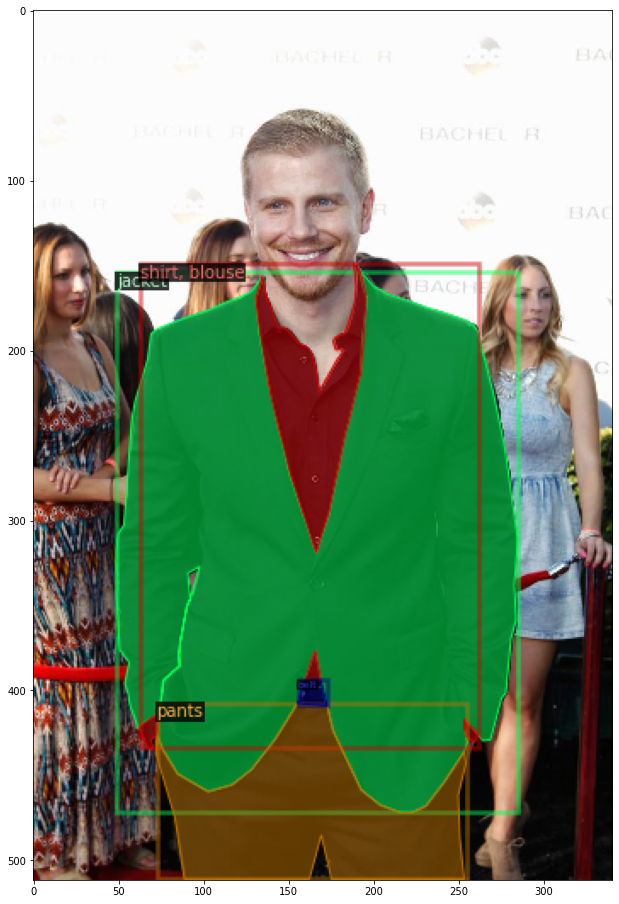

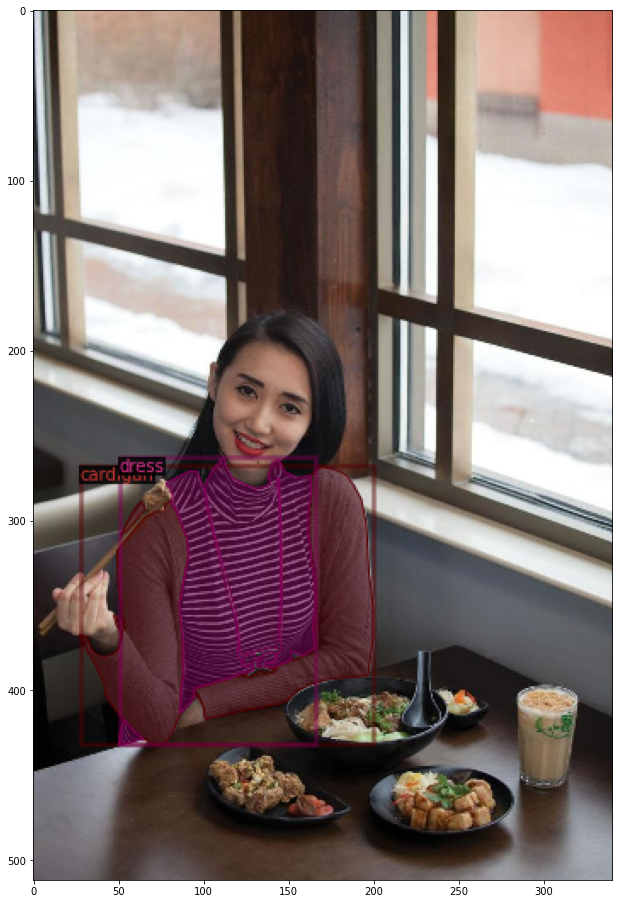

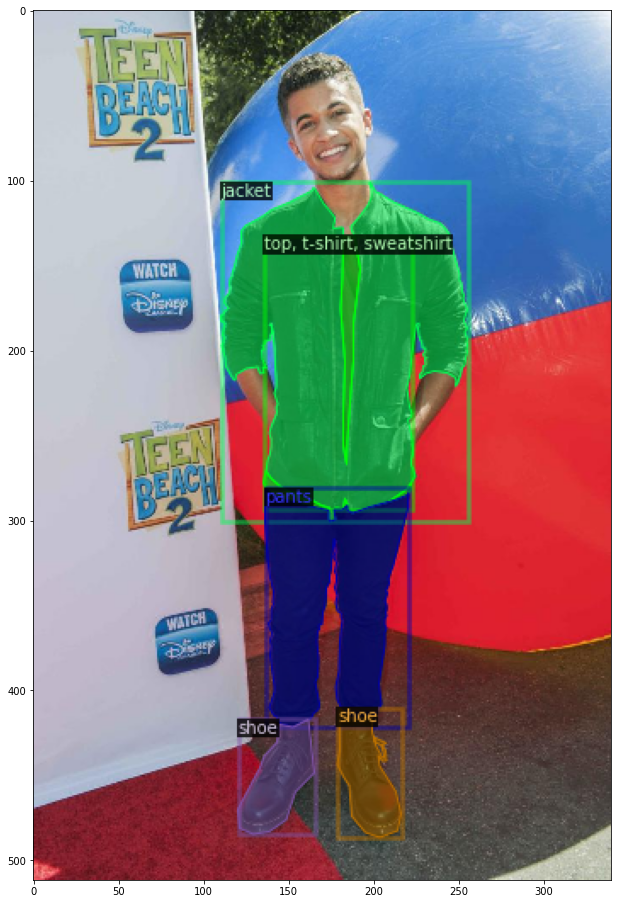

In [8]:

gt_list = []

for d in testlist:

    img = cv.imread(d["file_name"])
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=fashion_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(16,16))
    gt_list.append(vis.get_image()[:, :, ::-1])
    plt.imshow(gt_list[-1])
    

In [13]:
#dataset_dicts[3]

In [14]:
#plt.imshow(a)

In [15]:
########### Lets make a class

In [9]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

In [10]:
import logging

In [11]:
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

In [12]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=30,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)
        
#https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b#file-lossevalhook-py

In [13]:
class fashionTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [14]:
import detectron2.structures
from detectron2.structures import pairwise_iou


In [22]:
# bboxes_gt = structures.Boxes(torch.Tensor(bboxes_gt))
# bboxes_pred = outputs["instances"].pred_boxes
# IOUs = structures.pairwise_iou(bboxes_gt, bboxes_pred)

In [15]:
from detectron2 import model_zoo

cfg = get_cfg()

In [16]:
#cfg.merge_from_file("detectron2/configs/Misc/scratch_mask_rcnn_R_50_FPN_3x_gn.yaml")
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("detectron2/configs/Misc/scratch_mask_rcnn_R_50_FPN_3x_gn.yaml")

In [17]:
#cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fashion_train",)
cfg.DATASETS.TEST = ('fashion_val',)  
#cfg.DATASETS.TEST = ('fashion2_val',)  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 1


############################모델패스############################################
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "log/22_model_0004999.pth")
############################모델패스############################################

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000199.pth") 
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    4
)  # faster, and good enough for this toy dataset
cfg.INPUT.MIN_SIZE_TRAIN = (500,)


###############################################################################
########################### 조정하면서 관찰하셔야 하는 수치들 ####################
###############################################################################

cfg.SOLVER.BASE_LR = 0.0001

### lms상에서 10000 iter 넘어가면서부터 ssh 에러 확률 상승
### 3000 = 9시간
cfg.SOLVER.MAX_ITER = (
    25000
)  # 300 iterations seems good enough, but you can certainly train longer
####새 annotation 적용 시 23 (정도, 에러나면 수정 직접 해주세요 ㅅㅁㅅ)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 23    #47
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 23    #47
cfg.INPUT.MASK_FORMAT='bitmask'

### 다음 두 수치는 숫자를 맞춰주세요
### eval은 7분정도 걸립니다, 너무 자주하면 안좋겠지만, 너무 띄엄띄엄해도 볼 수 있는 수치가 없겠죠?
### 500 정도면 괜찮을거 같은데, train iteration에 맞춰서 조정 부탁드리겠슴다
cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

###############################################################################

#cfg.SOLVER.GAMMA = 0.1
#cfg.SOLVER.STEPS = (15000,)

# Freeze the first several stages so they are not trained.
# There are 5 stages in ResNet. The first is a convolution, and the following
# stages are each group of residual blocks
cfg.MODEL.BACKBONE.FREEZE_AT = 5



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [26]:
#cfg

In [27]:
#cfg.OUTPUT_DIR

In [28]:
#pwd

In [18]:
trainer = fashionTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/28 18:12:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/28 18:12:46 d2.data.datasets.coco]: Loading Fashionpedia/instances_atrributes_train2020_new.json takes 4.82 seconds.
[03/28 18:12:47 d2.data.datasets.coco]: Loaded 45602 images in COCO format from Fashionpedia/instances_atrributes_train2020_new.json
[03/28 18:12:48 d2.data.build]: Removed 0 images with no usable annotations. 45602 images left.
[03/28 18:12:50 d2.data.build]: Distribution of instances among all 22 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| shirt, blouse | 6161         | top, t-shir.. | 16548        |    sweater    | 1494         |
|   cardigan    | 1107         |    jacket     | 7833         |     vest      | 719          |
|     pants     | 12414        |    shorts     | 2756         |     skirt     | 5046         |
|     coat      | 3124         |     dress     | 18739        |   jumpsuit    | 922         

[03/28 18:15:45 d2.utils.events]:  eta: 3:19:34  iter: 299  total_loss: 1.049  loss_cls: 0.2511  loss_box_reg: 0.4202  loss_mask: 0.2356  loss_rpn_cls: 0.02078  loss_rpn_loc: 0.0226    time: 0.4882  last_time: 0.4892  data_time: 0.1610  last_data_time: 0.1531   lr: 2.997e-05  max_mem: 2374M
[03/28 18:15:55 d2.utils.events]:  eta: 3:19:27  iter: 319  total_loss: 0.818  loss_cls: 0.222  loss_box_reg: 0.3872  loss_mask: 0.1821  loss_rpn_cls: 0.01668  loss_rpn_loc: 0.01704    time: 0.4884  last_time: 0.3268  data_time: 0.1547  last_data_time: 0.0041   lr: 3.1968e-05  max_mem: 2374M
[03/28 18:16:05 d2.utils.events]:  eta: 3:19:22  iter: 339  total_loss: 1.131  loss_cls: 0.3312  loss_box_reg: 0.5412  loss_mask: 0.2375  loss_rpn_cls: 0.02429  loss_rpn_loc: 0.02552    time: 0.4883  last_time: 0.4898  data_time: 0.1559  last_data_time: 0.1473   lr: 3.3966e-05  max_mem: 2374M
[03/28 18:16:15 d2.utils.events]:  eta: 3:20:01  iter: 359  total_loss: 0.976  loss_cls: 0.2424  loss_box_reg: 0.4308  lo

[03/28 18:20:24 d2.utils.events]:  eta: 3:17:15  iter: 859  total_loss: 0.9519  loss_cls: 0.266  loss_box_reg: 0.4104  loss_mask: 0.2158  loss_rpn_cls: 0.0248  loss_rpn_loc: 0.01999    time: 0.4944  last_time: 0.4014  data_time: 0.1533  last_data_time: 0.1060   lr: 8.5914e-05  max_mem: 2374M
[03/28 18:20:34 d2.utils.events]:  eta: 3:16:52  iter: 879  total_loss: 0.874  loss_cls: 0.153  loss_box_reg: 0.3742  loss_mask: 0.2143  loss_rpn_cls: 0.0205  loss_rpn_loc: 0.02401    time: 0.4941  last_time: 0.4757  data_time: 0.1459  last_data_time: 0.1387   lr: 8.7912e-05  max_mem: 2374M
[03/28 18:20:44 d2.utils.events]:  eta: 3:16:36  iter: 899  total_loss: 0.9509  loss_cls: 0.2517  loss_box_reg: 0.424  loss_mask: 0.2142  loss_rpn_cls: 0.03064  loss_rpn_loc: 0.02861    time: 0.4943  last_time: 0.4714  data_time: 0.1592  last_data_time: 0.1497   lr: 8.991e-05  max_mem: 2374M
[03/28 18:20:54 d2.utils.events]:  eta: 3:16:26  iter: 919  total_loss: 0.8633  loss_cls: 0.2398  loss_box_reg: 0.3327  lo

[03/28 18:24:03 d2.evaluation.evaluator]: Inference done 628/1158. Dataloading: 0.0016 s/iter. Inference: 0.1335 s/iter. Eval: 0.0972 s/iter. Total: 0.2324 s/iter. ETA=0:02:03
[03/28 18:24:08 d2.evaluation.evaluator]: Inference done 649/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter. Eval: 0.0975 s/iter. Total: 0.2329 s/iter. ETA=0:01:58
[03/28 18:24:13 d2.evaluation.evaluator]: Inference done 671/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter. Eval: 0.0975 s/iter. Total: 0.2329 s/iter. ETA=0:01:53
[03/28 18:24:18 d2.evaluation.evaluator]: Inference done 693/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter. Eval: 0.0975 s/iter. Total: 0.2328 s/iter. ETA=0:01:48
[03/28 18:24:24 d2.evaluation.evaluator]: Inference done 716/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter. Eval: 0.0974 s/iter. Total: 0.2328 s/iter. ETA=0:01:42
[03/28 18:24:29 d2.evaluation.evaluator]: Inference done 739/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter.

DONE (t=0.81s)
creating index...
index created!
[03/28 18:26:13 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[03/28 18:26:15 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 2.71 seconds.
[03/28 18:26:15 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 18:26:16 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.37 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.

[03/28 18:29:45 d2.utils.events]:  eta: 3:13:23  iter: 1279  total_loss: 0.9178  loss_cls: 0.1596  loss_box_reg: 0.4073  loss_mask: 0.2247  loss_rpn_cls: 0.02173  loss_rpn_loc: 0.01682  validation_loss: 1.15    time: 0.4933  last_time: 0.5380  data_time: 0.1500  last_data_time: 0.1214   lr: 0.0001  max_mem: 2374M
[03/28 18:29:55 d2.utils.events]:  eta: 3:13:07  iter: 1299  total_loss: 0.9928  loss_cls: 0.2311  loss_box_reg: 0.4188  loss_mask: 0.2262  loss_rpn_cls: 0.02323  loss_rpn_loc: 0.02174  validation_loss: 1.15    time: 0.4932  last_time: 0.4355  data_time: 0.1467  last_data_time: 0.1208   lr: 0.0001  max_mem: 2374M
[03/28 18:30:05 d2.utils.events]:  eta: 3:12:35  iter: 1319  total_loss: 1.108  loss_cls: 0.3208  loss_box_reg: 0.4481  loss_mask: 0.2392  loss_rpn_cls: 0.0259  loss_rpn_loc: 0.02033  validation_loss: 1.15    time: 0.4929  last_time: 0.4765  data_time: 0.1444  last_data_time: 0.1565   lr: 0.0001  max_mem: 2374M
[03/28 18:30:14 d2.utils.events]:  eta: 3:12:17  iter: 13

[03/28 18:33:59 d2.utils.events]:  eta: 3:06:40  iter: 1799  total_loss: 1.052  loss_cls: 0.2411  loss_box_reg: 0.4461  loss_mask: 0.1858  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.02179  validation_loss: 1.15    time: 0.4916  last_time: 0.5021  data_time: 0.1452  last_data_time: 0.1198   lr: 0.0001  max_mem: 2374M
[03/28 18:34:09 d2.utils.events]:  eta: 3:06:34  iter: 1819  total_loss: 0.885  loss_cls: 0.27  loss_box_reg: 0.3787  loss_mask: 0.2191  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.02068  validation_loss: 1.15    time: 0.4915  last_time: 0.4872  data_time: 0.1495  last_data_time: 0.1420   lr: 0.0001  max_mem: 2374M
[03/28 18:34:18 d2.utils.events]:  eta: 3:06:22  iter: 1839  total_loss: 1.017  loss_cls: 0.2131  loss_box_reg: 0.4427  loss_mask: 0.2086  loss_rpn_cls: 0.02668  loss_rpn_loc: 0.02356  validation_loss: 1.15    time: 0.4912  last_time: 0.3053  data_time: 0.1345  last_data_time: 0.0045   lr: 0.0001  max_mem: 2374M
[03/28 18:34:28 d2.utils.events]:  eta: 3:06:12  iter: 1859 

[03/28 18:37:34 d2.evaluation.evaluator]: Inference done 479/1158. Dataloading: 0.0016 s/iter. Inference: 0.1343 s/iter. Eval: 0.1050 s/iter. Total: 0.2411 s/iter. ETA=0:02:43
[03/28 18:37:40 d2.evaluation.evaluator]: Inference done 500/1158. Dataloading: 0.0016 s/iter. Inference: 0.1344 s/iter. Eval: 0.1053 s/iter. Total: 0.2415 s/iter. ETA=0:02:38
[03/28 18:37:45 d2.evaluation.evaluator]: Inference done 519/1158. Dataloading: 0.0016 s/iter. Inference: 0.1345 s/iter. Eval: 0.1061 s/iter. Total: 0.2424 s/iter. ETA=0:02:34
[03/28 18:37:50 d2.evaluation.evaluator]: Inference done 541/1158. Dataloading: 0.0016 s/iter. Inference: 0.1345 s/iter. Eval: 0.1057 s/iter. Total: 0.2419 s/iter. ETA=0:02:29
[03/28 18:37:55 d2.evaluation.evaluator]: Inference done 563/1158. Dataloading: 0.0016 s/iter. Inference: 0.1345 s/iter. Eval: 0.1052 s/iter. Total: 0.2414 s/iter. ETA=0:02:23
[03/28 18:38:00 d2.evaluation.evaluator]: Inference done 582/1158. Dataloading: 0.0016 s/iter. Inference: 0.1346 s/iter.

[03/28 18:40:23 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 15.231 | top, t-shirt, sweatshirt | 28.622 | sweater                                 | 12.752 |
| cardigan          | 4.317  | jacket                   | 31.873 | vest                                    | 3.431  |
| pants             | 36.456 | shorts                   | 31.636 | skirt                                   | 26.944 |
| coat              | 30.951 | dress                    | 40.250 | jumpsuit                                | 0.836  |
| glasses           | 47.952 | hat                      | 39.032 | headband, head covering, hair accessory | 8.280  |
| tie               | 11.752 | glove                    | 2.208  | belt                                

[03/28 18:43:17 d2.utils.events]:  eta: 3:03:46  iter: 2199  total_loss: 1.006  loss_cls: 0.2446  loss_box_reg: 0.4181  loss_mask: 0.2053  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.02241  validation_loss: 1.18    time: 0.4905  last_time: 0.4684  data_time: 0.1444  last_data_time: 0.1272   lr: 0.0001  max_mem: 2374M
[03/28 18:43:27 d2.utils.events]:  eta: 3:03:37  iter: 2219  total_loss: 1.111  loss_cls: 0.2642  loss_box_reg: 0.4705  loss_mask: 0.2189  loss_rpn_cls: 0.02646  loss_rpn_loc: 0.02835  validation_loss: 1.18    time: 0.4905  last_time: 0.5287  data_time: 0.1546  last_data_time: 0.1833   lr: 0.0001  max_mem: 2374M
[03/28 18:43:37 d2.utils.events]:  eta: 3:03:31  iter: 2239  total_loss: 0.836  loss_cls: 0.2198  loss_box_reg: 0.4006  loss_mask: 0.2125  loss_rpn_cls: 0.02699  loss_rpn_loc: 0.0195  validation_loss: 1.18    time: 0.4905  last_time: 0.5470  data_time: 0.1514  last_data_time: 0.1408   lr: 0.0001  max_mem: 2374M
[03/28 18:43:47 d2.utils.events]:  eta: 3:03:23  iter: 2259

[03/28 18:47:34 d2.utils.events]:  eta: 3:00:50  iter: 2719  total_loss: 1.021  loss_cls: 0.2295  loss_box_reg: 0.4547  loss_mask: 0.2637  loss_rpn_cls: 0.02437  loss_rpn_loc: 0.0226  validation_loss: 1.18    time: 0.4911  last_time: 0.5427  data_time: 0.1719  last_data_time: 0.1991   lr: 0.0001  max_mem: 2374M
[03/28 18:47:44 d2.utils.events]:  eta: 3:00:30  iter: 2739  total_loss: 1.047  loss_cls: 0.328  loss_box_reg: 0.3903  loss_mask: 0.215  loss_rpn_cls: 0.03213  loss_rpn_loc: 0.02936  validation_loss: 1.18    time: 0.4911  last_time: 0.3839  data_time: 0.1448  last_data_time: 0.0860   lr: 0.0001  max_mem: 2374M
[03/28 18:47:54 d2.utils.events]:  eta: 3:00:28  iter: 2759  total_loss: 1.071  loss_cls: 0.2636  loss_box_reg: 0.4804  loss_mask: 0.2498  loss_rpn_cls: 0.02521  loss_rpn_loc: 0.02944  validation_loss: 1.18    time: 0.4912  last_time: 0.3217  data_time: 0.1605  last_data_time: 0.0047   lr: 0.0001  max_mem: 2374M
[03/28 18:48:04 d2.utils.events]:  eta: 3:00:21  iter: 2779  

[03/28 18:51:15 d2.evaluation.evaluator]: Inference done 374/1158. Dataloading: 0.0016 s/iter. Inference: 0.1310 s/iter. Eval: 0.0804 s/iter. Total: 0.2131 s/iter. ETA=0:02:47
[03/28 18:51:20 d2.evaluation.evaluator]: Inference done 397/1158. Dataloading: 0.0016 s/iter. Inference: 0.1310 s/iter. Eval: 0.0810 s/iter. Total: 0.2137 s/iter. ETA=0:02:42
[03/28 18:51:25 d2.evaluation.evaluator]: Inference done 421/1158. Dataloading: 0.0016 s/iter. Inference: 0.1312 s/iter. Eval: 0.0807 s/iter. Total: 0.2136 s/iter. ETA=0:02:37
[03/28 18:51:31 d2.evaluation.evaluator]: Inference done 446/1158. Dataloading: 0.0016 s/iter. Inference: 0.1312 s/iter. Eval: 0.0804 s/iter. Total: 0.2133 s/iter. ETA=0:02:31
[03/28 18:51:36 d2.evaluation.evaluator]: Inference done 469/1158. Dataloading: 0.0016 s/iter. Inference: 0.1311 s/iter. Eval: 0.0809 s/iter. Total: 0.2137 s/iter. ETA=0:02:27
[03/28 18:51:41 d2.evaluation.evaluator]: Inference done 492/1158. Dataloading: 0.0016 s/iter. Inference: 0.1312 s/iter.

[03/28 18:54:08 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 16.238 | top, t-shirt, sweatshirt | 28.600 | sweater                                 | 13.966 |
| cardigan          | 3.114  | jacket                   | 32.433 | vest                                    | 3.076  |
| pants             | 38.080 | shorts                   | 32.311 | skirt                                   | 27.612 |
| coat              | 30.554 | dress                    | 44.799 | jumpsuit                                | 0.924  |
| glasses           | 46.536 | hat                      | 42.012 | headband, head covering, hair accessory | 8.750  |
| tie               | 10.246 | glove                    | 1.916  | belt                                

[03/28 18:57:01 d2.utils.events]:  eta: 2:57:06  iter: 3199  total_loss: 1.104  loss_cls: 0.3602  loss_box_reg: 0.473  loss_mask: 0.2419  loss_rpn_cls: 0.0275  loss_rpn_loc: 0.02305  validation_loss: 1.181    time: 0.4909  last_time: 0.5277  data_time: 0.1546  last_data_time: 0.1639   lr: 0.0001  max_mem: 2374M
[03/28 18:57:11 d2.utils.events]:  eta: 2:57:02  iter: 3219  total_loss: 0.9336  loss_cls: 0.298  loss_box_reg: 0.388  loss_mask: 0.1912  loss_rpn_cls: 0.0259  loss_rpn_loc: 0.02363  validation_loss: 1.181    time: 0.4910  last_time: 0.5188  data_time: 0.1534  last_data_time: 0.1332   lr: 0.0001  max_mem: 2374M
[03/28 18:57:21 d2.utils.events]:  eta: 2:56:46  iter: 3239  total_loss: 0.9932  loss_cls: 0.2886  loss_box_reg: 0.4252  loss_mask: 0.2358  loss_rpn_cls: 0.02867  loss_rpn_loc: 0.02187  validation_loss: 1.181    time: 0.4909  last_time: 0.5147  data_time: 0.1535  last_data_time: 0.1961   lr: 0.0001  max_mem: 2374M
[03/28 18:57:31 d2.utils.events]:  eta: 2:56:36  iter: 325

[03/28 19:01:16 d2.utils.events]:  eta: 2:51:42  iter: 3719  total_loss: 0.953  loss_cls: 0.2476  loss_box_reg: 0.4616  loss_mask: 0.2166  loss_rpn_cls: 0.0307  loss_rpn_loc: 0.02764  validation_loss: 1.181    time: 0.4907  last_time: 0.5089  data_time: 0.1493  last_data_time: 0.1906   lr: 0.0001  max_mem: 2374M
[03/28 19:01:26 d2.utils.events]:  eta: 2:51:32  iter: 3739  total_loss: 0.8947  loss_cls: 0.2405  loss_box_reg: 0.4062  loss_mask: 0.2424  loss_rpn_cls: 0.02456  loss_rpn_loc: 0.02269  validation_loss: 1.181    time: 0.4907  last_time: 0.5070  data_time: 0.1591  last_data_time: 0.1945   lr: 0.0001  max_mem: 2374M
[03/28 19:01:36 d2.utils.events]:  eta: 2:51:28  iter: 3759  total_loss: 1.124  loss_cls: 0.2348  loss_box_reg: 0.444  loss_mask: 0.2145  loss_rpn_cls: 0.02456  loss_rpn_loc: 0.0271  validation_loss: 1.181    time: 0.4907  last_time: 0.5424  data_time: 0.1574  last_data_time: 0.1972   lr: 0.0001  max_mem: 2374M
[03/28 19:01:46 d2.utils.events]:  eta: 2:51:09  iter: 37

[03/28 19:04:55 d2.evaluation.evaluator]: Inference done 364/1158. Dataloading: 0.0016 s/iter. Inference: 0.1316 s/iter. Eval: 0.0853 s/iter. Total: 0.2187 s/iter. ETA=0:02:53
[03/28 19:05:00 d2.evaluation.evaluator]: Inference done 386/1158. Dataloading: 0.0016 s/iter. Inference: 0.1317 s/iter. Eval: 0.0858 s/iter. Total: 0.2192 s/iter. ETA=0:02:49
[03/28 19:05:05 d2.evaluation.evaluator]: Inference done 409/1158. Dataloading: 0.0016 s/iter. Inference: 0.1318 s/iter. Eval: 0.0859 s/iter. Total: 0.2194 s/iter. ETA=0:02:44
[03/28 19:05:10 d2.evaluation.evaluator]: Inference done 432/1158. Dataloading: 0.0016 s/iter. Inference: 0.1318 s/iter. Eval: 0.0860 s/iter. Total: 0.2196 s/iter. ETA=0:02:39
[03/28 19:05:16 d2.evaluation.evaluator]: Inference done 454/1158. Dataloading: 0.0016 s/iter. Inference: 0.1318 s/iter. Eval: 0.0865 s/iter. Total: 0.2200 s/iter. ETA=0:02:34
[03/28 19:05:21 d2.evaluation.evaluator]: Inference done 478/1158. Dataloading: 0.0016 s/iter. Inference: 0.1318 s/iter.

[03/28 19:07:55 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 14.372 | top, t-shirt, sweatshirt | 30.739 | sweater                                 | 16.683 |
| cardigan          | 3.383  | jacket                   | 34.182 | vest                                    | 4.104  |
| pants             | 37.012 | shorts                   | 31.994 | skirt                                   | 27.247 |
| coat              | 33.429 | dress                    | 42.401 | jumpsuit                                | 0.964  |
| glasses           | 45.066 | hat                      | 42.516 | headband, head covering, hair accessory | 8.355  |
| tie               | 15.148 | glove                    | 1.850  | belt                                

[03/28 19:10:50 d2.utils.events]:  eta: 2:48:00  iter: 4199  total_loss: 0.829  loss_cls: 0.2598  loss_box_reg: 0.3905  loss_mask: 0.2248  loss_rpn_cls: 0.02317  loss_rpn_loc: 0.02474  validation_loss: 1.18    time: 0.4906  last_time: 0.5332  data_time: 0.1401  last_data_time: 0.1781   lr: 0.0001  max_mem: 2374M
[03/28 19:11:00 d2.utils.events]:  eta: 2:47:52  iter: 4219  total_loss: 1.072  loss_cls: 0.2605  loss_box_reg: 0.4858  loss_mask: 0.2314  loss_rpn_cls: 0.02572  loss_rpn_loc: 0.02447  validation_loss: 1.18    time: 0.4908  last_time: 0.4745  data_time: 0.1574  last_data_time: 0.1552   lr: 0.0001  max_mem: 2374M
[03/28 19:11:10 d2.utils.events]:  eta: 2:47:45  iter: 4239  total_loss: 1.052  loss_cls: 0.2393  loss_box_reg: 0.457  loss_mask: 0.224  loss_rpn_cls: 0.02035  loss_rpn_loc: 0.01792  validation_loss: 1.18    time: 0.4907  last_time: 0.5137  data_time: 0.1495  last_data_time: 0.1993   lr: 0.0001  max_mem: 2374M
[03/28 19:11:19 d2.utils.events]:  eta: 2:47:13  iter: 4259 

[03/28 19:15:07 d2.utils.events]:  eta: 2:44:47  iter: 4719  total_loss: 1.001  loss_cls: 0.2675  loss_box_reg: 0.4207  loss_mask: 0.2792  loss_rpn_cls: 0.02525  loss_rpn_loc: 0.02419  validation_loss: 1.18    time: 0.4911  last_time: 0.5406  data_time: 0.1747  last_data_time: 0.1598   lr: 0.0001  max_mem: 2374M
[03/28 19:15:17 d2.utils.events]:  eta: 2:44:37  iter: 4739  total_loss: 1.111  loss_cls: 0.2977  loss_box_reg: 0.4669  loss_mask: 0.2465  loss_rpn_cls: 0.02074  loss_rpn_loc: 0.0214  validation_loss: 1.18    time: 0.4911  last_time: 0.4651  data_time: 0.1631  last_data_time: 0.1491   lr: 0.0001  max_mem: 2374M
[03/28 19:15:27 d2.utils.events]:  eta: 2:44:12  iter: 4759  total_loss: 0.8836  loss_cls: 0.2273  loss_box_reg: 0.3768  loss_mask: 0.1965  loss_rpn_cls: 0.02646  loss_rpn_loc: 0.01905  validation_loss: 1.18    time: 0.4911  last_time: 0.5543  data_time: 0.1482  last_data_time: 0.2338   lr: 0.0001  max_mem: 2374M
[03/28 19:15:37 d2.utils.events]:  eta: 2:44:15  iter: 477

[03/28 19:18:46 d2.evaluation.evaluator]: Inference done 338/1158. Dataloading: 0.0017 s/iter. Inference: 0.1340 s/iter. Eval: 0.0992 s/iter. Total: 0.2351 s/iter. ETA=0:03:12
[03/28 19:18:51 d2.evaluation.evaluator]: Inference done 361/1158. Dataloading: 0.0017 s/iter. Inference: 0.1337 s/iter. Eval: 0.0984 s/iter. Total: 0.2340 s/iter. ETA=0:03:06
[03/28 19:18:57 d2.evaluation.evaluator]: Inference done 382/1158. Dataloading: 0.0017 s/iter. Inference: 0.1339 s/iter. Eval: 0.0991 s/iter. Total: 0.2348 s/iter. ETA=0:03:02
[03/28 19:19:02 d2.evaluation.evaluator]: Inference done 404/1158. Dataloading: 0.0017 s/iter. Inference: 0.1338 s/iter. Eval: 0.0988 s/iter. Total: 0.2344 s/iter. ETA=0:02:56
[03/28 19:19:07 d2.evaluation.evaluator]: Inference done 425/1158. Dataloading: 0.0017 s/iter. Inference: 0.1340 s/iter. Eval: 0.0992 s/iter. Total: 0.2351 s/iter. ETA=0:02:52
[03/28 19:19:12 d2.evaluation.evaluator]: Inference done 447/1158. Dataloading: 0.0017 s/iter. Inference: 0.1339 s/iter.

[03/28 19:22:02 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 15.176 | top, t-shirt, sweatshirt | 28.700 | sweater                                 | 15.676 |
| cardigan          | 5.088  | jacket                   | 32.582 | vest                                    | 4.423  |
| pants             | 38.357 | shorts                   | 27.994 | skirt                                   | 27.269 |
| coat              | 31.273 | dress                    | 45.107 | jumpsuit                                | 1.075  |
| glasses           | 46.265 | hat                      | 41.289 | headband, head covering, hair accessory | 7.919  |
| tie               | 12.037 | glove                    | 1.837  | belt                                

[03/28 19:24:58 d2.utils.events]:  eta: 2:41:20  iter: 5199  total_loss: 0.9238  loss_cls: 0.2237  loss_box_reg: 0.3627  loss_mask: 0.2296  loss_rpn_cls: 0.02308  loss_rpn_loc: 0.02669  validation_loss: 1.188    time: 0.4914  last_time: 0.4557  data_time: 0.1614  last_data_time: 0.1384   lr: 0.0001  max_mem: 2374M
[03/28 19:25:07 d2.utils.events]:  eta: 2:40:43  iter: 5219  total_loss: 1.004  loss_cls: 0.267  loss_box_reg: 0.4246  loss_mask: 0.2114  loss_rpn_cls: 0.02555  loss_rpn_loc: 0.02177  validation_loss: 1.188    time: 0.4913  last_time: 0.4576  data_time: 0.1336  last_data_time: 0.1158   lr: 0.0001  max_mem: 2374M
[03/28 19:25:17 d2.utils.events]:  eta: 2:40:38  iter: 5239  total_loss: 0.9955  loss_cls: 0.3006  loss_box_reg: 0.3853  loss_mask: 0.1852  loss_rpn_cls: 0.0256  loss_rpn_loc: 0.02716  validation_loss: 1.188    time: 0.4913  last_time: 0.3278  data_time: 0.1505  last_data_time: 0.0067   lr: 0.0001  max_mem: 2374M
[03/28 19:25:27 d2.utils.events]:  eta: 2:40:58  iter: 

[03/28 19:29:15 d2.utils.events]:  eta: 2:36:47  iter: 5719  total_loss: 1.031  loss_cls: 0.2379  loss_box_reg: 0.5085  loss_mask: 0.2186  loss_rpn_cls: 0.02625  loss_rpn_loc: 0.02565  validation_loss: 1.188    time: 0.4916  last_time: 0.4454  data_time: 0.1545  last_data_time: 0.1334   lr: 0.0001  max_mem: 2374M
[03/28 19:29:25 d2.utils.events]:  eta: 2:36:21  iter: 5739  total_loss: 1.05  loss_cls: 0.3019  loss_box_reg: 0.4558  loss_mask: 0.2514  loss_rpn_cls: 0.01981  loss_rpn_loc: 0.0228  validation_loss: 1.188    time: 0.4916  last_time: 0.4477  data_time: 0.1314  last_data_time: 0.1051   lr: 0.0001  max_mem: 2374M
[03/28 19:29:35 d2.utils.events]:  eta: 2:36:26  iter: 5759  total_loss: 1.104  loss_cls: 0.23  loss_box_reg: 0.4681  loss_mask: 0.2605  loss_rpn_cls: 0.02097  loss_rpn_loc: 0.02318  validation_loss: 1.188    time: 0.4916  last_time: 0.6259  data_time: 0.1596  last_data_time: 0.2627   lr: 0.0001  max_mem: 2374M
[03/28 19:29:44 d2.utils.events]:  eta: 2:36:07  iter: 5779

[03/28 19:32:54 d2.evaluation.evaluator]: Inference done 334/1158. Dataloading: 0.0016 s/iter. Inference: 0.1341 s/iter. Eval: 0.1032 s/iter. Total: 0.2391 s/iter. ETA=0:03:16
[03/28 19:32:59 d2.evaluation.evaluator]: Inference done 358/1158. Dataloading: 0.0016 s/iter. Inference: 0.1336 s/iter. Eval: 0.1017 s/iter. Total: 0.2371 s/iter. ETA=0:03:09
[03/28 19:33:04 d2.evaluation.evaluator]: Inference done 379/1158. Dataloading: 0.0016 s/iter. Inference: 0.1337 s/iter. Eval: 0.1022 s/iter. Total: 0.2377 s/iter. ETA=0:03:05
[03/28 19:33:09 d2.evaluation.evaluator]: Inference done 401/1158. Dataloading: 0.0016 s/iter. Inference: 0.1338 s/iter. Eval: 0.1022 s/iter. Total: 0.2377 s/iter. ETA=0:02:59
[03/28 19:33:15 d2.evaluation.evaluator]: Inference done 424/1158. Dataloading: 0.0016 s/iter. Inference: 0.1338 s/iter. Eval: 0.1016 s/iter. Total: 0.2372 s/iter. ETA=0:02:54
[03/28 19:33:20 d2.evaluation.evaluator]: Inference done 446/1158. Dataloading: 0.0016 s/iter. Inference: 0.1338 s/iter.

[03/28 19:36:11 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 14.855 | top, t-shirt, sweatshirt | 28.830 | sweater                                 | 16.423 |
| cardigan          | 4.452  | jacket                   | 31.782 | vest                                    | 3.510  |
| pants             | 37.648 | shorts                   | 29.973 | skirt                                   | 26.313 |
| coat              | 26.822 | dress                    | 44.965 | jumpsuit                                | 1.080  |
| glasses           | 46.566 | hat                      | 38.396 | headband, head covering, hair accessory | 7.732  |
| tie               | 10.289 | glove                    | 1.444  | belt                                

[03/28 19:39:06 d2.utils.events]:  eta: 2:32:02  iter: 6199  total_loss: 0.9881  loss_cls: 0.2867  loss_box_reg: 0.3883  loss_mask: 0.2225  loss_rpn_cls: 0.03004  loss_rpn_loc: 0.02434  validation_loss: 1.208    time: 0.4915  last_time: 0.4736  data_time: 0.1536  last_data_time: 0.1408   lr: 0.0001  max_mem: 2374M
[03/28 19:39:15 d2.utils.events]:  eta: 2:31:53  iter: 6219  total_loss: 0.9866  loss_cls: 0.2311  loss_box_reg: 0.3974  loss_mask: 0.2033  loss_rpn_cls: 0.02333  loss_rpn_loc: 0.02006  validation_loss: 1.208    time: 0.4914  last_time: 0.4759  data_time: 0.1396  last_data_time: 0.1329   lr: 0.0001  max_mem: 2374M
[03/28 19:39:25 d2.utils.events]:  eta: 2:31:36  iter: 6239  total_loss: 0.7974  loss_cls: 0.2066  loss_box_reg: 0.3667  loss_mask: 0.2125  loss_rpn_cls: 0.01961  loss_rpn_loc: 0.02052  validation_loss: 1.208    time: 0.4914  last_time: 0.4408  data_time: 0.1554  last_data_time: 0.1196   lr: 0.0001  max_mem: 2374M
[03/28 19:39:35 d2.utils.events]:  eta: 2:31:28  ite

[03/28 19:43:20 d2.utils.events]:  eta: 2:26:39  iter: 6719  total_loss: 0.8429  loss_cls: 0.1666  loss_box_reg: 0.3857  loss_mask: 0.1887  loss_rpn_cls: 0.02001  loss_rpn_loc: 0.01953  validation_loss: 1.208    time: 0.4912  last_time: 0.4623  data_time: 0.1550  last_data_time: 0.1426   lr: 0.0001  max_mem: 2374M
[03/28 19:43:29 d2.utils.events]:  eta: 2:26:29  iter: 6739  total_loss: 1.031  loss_cls: 0.2704  loss_box_reg: 0.3897  loss_mask: 0.2632  loss_rpn_cls: 0.02464  loss_rpn_loc: 0.02292  validation_loss: 1.208    time: 0.4911  last_time: 0.4418  data_time: 0.1519  last_data_time: 0.1098   lr: 0.0001  max_mem: 2374M
[03/28 19:43:39 d2.utils.events]:  eta: 2:26:00  iter: 6759  total_loss: 0.8731  loss_cls: 0.2301  loss_box_reg: 0.3812  loss_mask: 0.2172  loss_rpn_cls: 0.02083  loss_rpn_loc: 0.01985  validation_loss: 1.208    time: 0.4911  last_time: 0.4523  data_time: 0.1376  last_data_time: 0.1332   lr: 0.0001  max_mem: 2374M
[03/28 19:43:49 d2.utils.events]:  eta: 2:25:55  iter

[03/28 19:46:56 d2.evaluation.evaluator]: Inference done 373/1158. Dataloading: 0.0015 s/iter. Inference: 0.1301 s/iter. Eval: 0.0804 s/iter. Total: 0.2121 s/iter. ETA=0:02:46
[03/28 19:47:01 d2.evaluation.evaluator]: Inference done 395/1158. Dataloading: 0.0015 s/iter. Inference: 0.1303 s/iter. Eval: 0.0813 s/iter. Total: 0.2133 s/iter. ETA=0:02:42
[03/28 19:47:06 d2.evaluation.evaluator]: Inference done 419/1158. Dataloading: 0.0016 s/iter. Inference: 0.1305 s/iter. Eval: 0.0811 s/iter. Total: 0.2132 s/iter. ETA=0:02:37
[03/28 19:47:11 d2.evaluation.evaluator]: Inference done 443/1158. Dataloading: 0.0016 s/iter. Inference: 0.1305 s/iter. Eval: 0.0811 s/iter. Total: 0.2132 s/iter. ETA=0:02:32
[03/28 19:47:17 d2.evaluation.evaluator]: Inference done 467/1158. Dataloading: 0.0016 s/iter. Inference: 0.1304 s/iter. Eval: 0.0815 s/iter. Total: 0.2136 s/iter. ETA=0:02:27
[03/28 19:47:22 d2.evaluation.evaluator]: Inference done 490/1158. Dataloading: 0.0015 s/iter. Inference: 0.1305 s/iter.

[03/28 19:49:48 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 12.795 | top, t-shirt, sweatshirt | 29.049 | sweater                                 | 18.256 |
| cardigan          | 3.640  | jacket                   | 34.794 | vest                                    | 4.928  |
| pants             | 36.182 | shorts                   | 31.553 | skirt                                   | 26.430 |
| coat              | 31.042 | dress                    | 43.892 | jumpsuit                                | 0.935  |
| glasses           | 45.930 | hat                      | 39.808 | headband, head covering, hair accessory | 10.941 |
| tie               | 7.507  | glove                    | 1.963  | belt                                

[03/28 19:52:39 d2.utils.events]:  eta: 2:22:41  iter: 7199  total_loss: 0.8639  loss_cls: 0.1864  loss_box_reg: 0.4403  loss_mask: 0.2569  loss_rpn_cls: 0.01914  loss_rpn_loc: 0.02545  validation_loss: 1.167    time: 0.4907  last_time: 0.8027  data_time: 0.1558  last_data_time: 0.3573   lr: 0.0001  max_mem: 2374M
[03/28 19:52:49 d2.utils.events]:  eta: 2:22:36  iter: 7219  total_loss: 1.095  loss_cls: 0.2628  loss_box_reg: 0.4258  loss_mask: 0.2304  loss_rpn_cls: 0.02738  loss_rpn_loc: 0.02231  validation_loss: 1.167    time: 0.4906  last_time: 0.4517  data_time: 0.1409  last_data_time: 0.1348   lr: 0.0001  max_mem: 2374M
[03/28 19:52:59 d2.utils.events]:  eta: 2:22:28  iter: 7239  total_loss: 1.079  loss_cls: 0.3592  loss_box_reg: 0.4625  loss_mask: 0.2493  loss_rpn_cls: 0.02499  loss_rpn_loc: 0.02112  validation_loss: 1.167    time: 0.4906  last_time: 0.3760  data_time: 0.1543  last_data_time: 0.0083   lr: 0.0001  max_mem: 2374M
[03/28 19:53:09 d2.utils.events]:  eta: 2:22:14  iter:

[03/28 19:56:53 d2.utils.events]:  eta: 2:18:49  iter: 7719  total_loss: 1.121  loss_cls: 0.2914  loss_box_reg: 0.4405  loss_mask: 0.187  loss_rpn_cls: 0.02412  loss_rpn_loc: 0.02245  validation_loss: 1.167    time: 0.4904  last_time: 0.4272  data_time: 0.1428  last_data_time: 0.1105   lr: 0.0001  max_mem: 2374M
[03/28 19:57:03 d2.utils.events]:  eta: 2:18:45  iter: 7739  total_loss: 0.8262  loss_cls: 0.2288  loss_box_reg: 0.3619  loss_mask: 0.24  loss_rpn_cls: 0.02321  loss_rpn_loc: 0.02319  validation_loss: 1.167    time: 0.4904  last_time: 0.5171  data_time: 0.1548  last_data_time: 0.1341   lr: 0.0001  max_mem: 2374M
[03/28 19:57:12 d2.utils.events]:  eta: 2:18:53  iter: 7759  total_loss: 1.043  loss_cls: 0.2647  loss_box_reg: 0.4454  loss_mask: 0.2036  loss_rpn_cls: 0.02057  loss_rpn_loc: 0.02301  validation_loss: 1.167    time: 0.4904  last_time: 0.5207  data_time: 0.1571  last_data_time: 0.1401   lr: 0.0001  max_mem: 2374M
[03/28 19:57:22 d2.utils.events]:  eta: 2:18:39  iter: 77

[03/28 20:00:31 d2.evaluation.evaluator]: Inference done 327/1158. Dataloading: 0.0016 s/iter. Inference: 0.1354 s/iter. Eval: 0.1064 s/iter. Total: 0.2435 s/iter. ETA=0:03:22
[03/28 20:00:36 d2.evaluation.evaluator]: Inference done 349/1158. Dataloading: 0.0016 s/iter. Inference: 0.1352 s/iter. Eval: 0.1057 s/iter. Total: 0.2426 s/iter. ETA=0:03:16
[03/28 20:00:42 d2.evaluation.evaluator]: Inference done 371/1158. Dataloading: 0.0016 s/iter. Inference: 0.1351 s/iter. Eval: 0.1058 s/iter. Total: 0.2426 s/iter. ETA=0:03:10
[03/28 20:00:47 d2.evaluation.evaluator]: Inference done 390/1158. Dataloading: 0.0016 s/iter. Inference: 0.1352 s/iter. Eval: 0.1069 s/iter. Total: 0.2438 s/iter. ETA=0:03:07
[03/28 20:00:52 d2.evaluation.evaluator]: Inference done 412/1158. Dataloading: 0.0016 s/iter. Inference: 0.1353 s/iter. Eval: 0.1061 s/iter. Total: 0.2431 s/iter. ETA=0:03:01
[03/28 20:00:57 d2.evaluation.evaluator]: Inference done 432/1158. Dataloading: 0.0016 s/iter. Inference: 0.1353 s/iter.

[03/28 20:03:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 20:03:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.28 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Recall     (

[03/28 20:06:15 d2.utils.events]:  eta: 2:15:55  iter: 8119  total_loss: 1.109  loss_cls: 0.2753  loss_box_reg: 0.4154  loss_mask: 0.2598  loss_rpn_cls: 0.02741  loss_rpn_loc: 0.02913  validation_loss: 1.188    time: 0.4906  last_time: 0.7364  data_time: 0.1654  last_data_time: 0.2807   lr: 0.0001  max_mem: 2374M
[03/28 20:06:24 d2.utils.events]:  eta: 2:15:42  iter: 8139  total_loss: 1.063  loss_cls: 0.281  loss_box_reg: 0.4688  loss_mask: 0.2039  loss_rpn_cls: 0.02822  loss_rpn_loc: 0.01986  validation_loss: 1.188    time: 0.4906  last_time: 0.6426  data_time: 0.1627  last_data_time: 0.3223   lr: 0.0001  max_mem: 2374M
[03/28 20:06:34 d2.utils.events]:  eta: 2:15:47  iter: 8159  total_loss: 0.9506  loss_cls: 0.3074  loss_box_reg: 0.4003  loss_mask: 0.2272  loss_rpn_cls: 0.02748  loss_rpn_loc: 0.02358  validation_loss: 1.188    time: 0.4906  last_time: 0.4468  data_time: 0.1478  last_data_time: 0.1304   lr: 0.0001  max_mem: 2374M
[03/28 20:06:45 d2.utils.events]:  eta: 2:15:45  iter: 

[03/28 20:10:31 d2.utils.events]:  eta: 2:12:25  iter: 8639  total_loss: 0.9972  loss_cls: 0.2289  loss_box_reg: 0.5345  loss_mask: 0.2172  loss_rpn_cls: 0.02003  loss_rpn_loc: 0.01913  validation_loss: 1.188    time: 0.4907  last_time: 0.3034  data_time: 0.1614  last_data_time: 0.0050   lr: 0.0001  max_mem: 2374M
[03/28 20:10:41 d2.utils.events]:  eta: 2:12:20  iter: 8659  total_loss: 1.087  loss_cls: 0.2901  loss_box_reg: 0.4365  loss_mask: 0.2234  loss_rpn_cls: 0.02767  loss_rpn_loc: 0.026  validation_loss: 1.188    time: 0.4907  last_time: 0.5274  data_time: 0.1702  last_data_time: 0.1530   lr: 0.0001  max_mem: 2374M
[03/28 20:10:51 d2.utils.events]:  eta: 2:12:08  iter: 8679  total_loss: 1.043  loss_cls: 0.2336  loss_box_reg: 0.4597  loss_mask: 0.2648  loss_rpn_cls: 0.02654  loss_rpn_loc: 0.02375  validation_loss: 1.188    time: 0.4907  last_time: 0.4606  data_time: 0.1478  last_data_time: 0.1369   lr: 0.0001  max_mem: 2374M
[03/28 20:11:01 d2.utils.events]:  eta: 2:12:01  iter: 8

[03/28 20:14:16 d2.evaluation.evaluator]: Inference done 182/1158. Dataloading: 0.0016 s/iter. Inference: 0.1352 s/iter. Eval: 0.1031 s/iter. Total: 0.2399 s/iter. ETA=0:03:54
[03/28 20:14:21 d2.evaluation.evaluator]: Inference done 204/1158. Dataloading: 0.0016 s/iter. Inference: 0.1350 s/iter. Eval: 0.1024 s/iter. Total: 0.2391 s/iter. ETA=0:03:48
[03/28 20:14:26 d2.evaluation.evaluator]: Inference done 227/1158. Dataloading: 0.0016 s/iter. Inference: 0.1347 s/iter. Eval: 0.1011 s/iter. Total: 0.2375 s/iter. ETA=0:03:41
[03/28 20:14:31 d2.evaluation.evaluator]: Inference done 247/1158. Dataloading: 0.0016 s/iter. Inference: 0.1347 s/iter. Eval: 0.1029 s/iter. Total: 0.2393 s/iter. ETA=0:03:38
[03/28 20:14:36 d2.evaluation.evaluator]: Inference done 270/1158. Dataloading: 0.0016 s/iter. Inference: 0.1344 s/iter. Eval: 0.1019 s/iter. Total: 0.2379 s/iter. ETA=0:03:31
[03/28 20:14:41 d2.evaluation.evaluator]: Inference done 292/1158. Dataloading: 0.0016 s/iter. Inference: 0.1341 s/iter.

[03/28 20:18:06 d2.evaluation.evaluator]: Inference done 1143/1158. Dataloading: 0.0016 s/iter. Inference: 0.1353 s/iter. Eval: 0.1026 s/iter. Total: 0.2396 s/iter. ETA=0:00:03
[03/28 20:18:09 d2.evaluation.evaluator]: Total inference time: 0:04:36.348950 (0.239678 s / iter per device, on 1 devices)
[03/28 20:18:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:02:36 (0.135308 s / iter per device, on 1 devices)
[03/28 20:18:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/28 20:18:10 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[03/28 20:18:11 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
[03/28 20:18:11 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[03/28 20:18:12 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 1.10 seconds.
[03/28 20:18:12 

[03/28 20:19:48 d2.utils.events]:  eta: 2:09:31  iter: 9039  total_loss: 1.068  loss_cls: 0.3091  loss_box_reg: 0.4656  loss_mask: 0.2303  loss_rpn_cls: 0.02171  loss_rpn_loc: 0.0199  validation_loss: 1.223    time: 0.4910  last_time: 0.4279  data_time: 0.1431  last_data_time: 0.1138   lr: 0.0001  max_mem: 2374M
[03/28 20:19:58 d2.utils.events]:  eta: 2:09:15  iter: 9059  total_loss: 0.9256  loss_cls: 0.2666  loss_box_reg: 0.3821  loss_mask: 0.1853  loss_rpn_cls: 0.03498  loss_rpn_loc: 0.03228  validation_loss: 1.223    time: 0.4910  last_time: 0.3964  data_time: 0.1542  last_data_time: 0.0804   lr: 0.0001  max_mem: 2374M
[03/28 20:20:08 d2.utils.events]:  eta: 2:09:01  iter: 9079  total_loss: 0.9044  loss_cls: 0.1974  loss_box_reg: 0.43  loss_mask: 0.2158  loss_rpn_cls: 0.02521  loss_rpn_loc: 0.02196  validation_loss: 1.223    time: 0.4910  last_time: 0.4637  data_time: 0.1700  last_data_time: 0.1197   lr: 0.0001  max_mem: 2374M
[03/28 20:20:17 d2.utils.events]:  eta: 2:08:47  iter: 9

[03/28 20:24:03 d2.utils.events]:  eta: 2:04:49  iter: 9559  total_loss: 1.035  loss_cls: 0.2558  loss_box_reg: 0.4622  loss_mask: 0.2111  loss_rpn_cls: 0.03838  loss_rpn_loc: 0.02406  validation_loss: 1.223    time: 0.4909  last_time: 0.6036  data_time: 0.1519  last_data_time: 0.0776   lr: 0.0001  max_mem: 2374M
[03/28 20:24:13 d2.utils.events]:  eta: 2:04:32  iter: 9579  total_loss: 0.9596  loss_cls: 0.2908  loss_box_reg: 0.3844  loss_mask: 0.2551  loss_rpn_cls: 0.0195  loss_rpn_loc: 0.01866  validation_loss: 1.223    time: 0.4909  last_time: 0.4898  data_time: 0.1392  last_data_time: 0.1716   lr: 0.0001  max_mem: 2374M
[03/28 20:24:22 d2.utils.events]:  eta: 2:04:15  iter: 9599  total_loss: 1.056  loss_cls: 0.2702  loss_box_reg: 0.3993  loss_mask: 0.2604  loss_rpn_cls: 0.02837  loss_rpn_loc: 0.02391  validation_loss: 1.223    time: 0.4909  last_time: 0.4689  data_time: 0.1519  last_data_time: 0.1554   lr: 0.0001  max_mem: 2374M
[03/28 20:24:32 d2.utils.events]:  eta: 2:04:10  iter: 

[03/28 20:27:47 d2.evaluation.evaluator]: Inference done 33/1158. Dataloading: 0.0016 s/iter. Inference: 0.1335 s/iter. Eval: 0.0990 s/iter. Total: 0.2342 s/iter. ETA=0:04:23
[03/28 20:27:52 d2.evaluation.evaluator]: Inference done 54/1158. Dataloading: 0.0016 s/iter. Inference: 0.1338 s/iter. Eval: 0.1008 s/iter. Total: 0.2363 s/iter. ETA=0:04:20
[03/28 20:27:57 d2.evaluation.evaluator]: Inference done 75/1158. Dataloading: 0.0016 s/iter. Inference: 0.1341 s/iter. Eval: 0.1034 s/iter. Total: 0.2392 s/iter. ETA=0:04:19
[03/28 20:28:02 d2.evaluation.evaluator]: Inference done 96/1158. Dataloading: 0.0016 s/iter. Inference: 0.1345 s/iter. Eval: 0.1032 s/iter. Total: 0.2394 s/iter. ETA=0:04:14
[03/28 20:28:07 d2.evaluation.evaluator]: Inference done 119/1158. Dataloading: 0.0016 s/iter. Inference: 0.1346 s/iter. Eval: 0.1001 s/iter. Total: 0.2364 s/iter. ETA=0:04:05
[03/28 20:28:13 d2.evaluation.evaluator]: Inference done 139/1158. Dataloading: 0.0016 s/iter. Inference: 0.1355 s/iter. Eva

[03/28 20:31:39 d2.evaluation.evaluator]: Inference done 1016/1158. Dataloading: 0.0016 s/iter. Inference: 0.1349 s/iter. Eval: 0.0990 s/iter. Total: 0.2356 s/iter. ETA=0:00:33
[03/28 20:31:44 d2.evaluation.evaluator]: Inference done 1037/1158. Dataloading: 0.0016 s/iter. Inference: 0.1349 s/iter. Eval: 0.0992 s/iter. Total: 0.2359 s/iter. ETA=0:00:28
[03/28 20:31:49 d2.evaluation.evaluator]: Inference done 1059/1158. Dataloading: 0.0016 s/iter. Inference: 0.1349 s/iter. Eval: 0.0992 s/iter. Total: 0.2358 s/iter. ETA=0:00:23
[03/28 20:31:54 d2.evaluation.evaluator]: Inference done 1079/1158. Dataloading: 0.0016 s/iter. Inference: 0.1349 s/iter. Eval: 0.0995 s/iter. Total: 0.2361 s/iter. ETA=0:00:18
[03/28 20:31:59 d2.evaluation.evaluator]: Inference done 1102/1158. Dataloading: 0.0016 s/iter. Inference: 0.1349 s/iter. Eval: 0.0992 s/iter. Total: 0.2359 s/iter. ETA=0:00:13
[03/28 20:32:04 d2.evaluation.evaluator]: Inference done 1125/1158. Dataloading: 0.0016 s/iter. Inference: 0.1348 s

[03/28 20:32:20 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 20:32:20 d2.evaluation.testing]: copypaste: 20.3900,38.8147,19.5019,2.9936,15.5828,26.1754
[03/28 20:32:21 detectron2]: Loss on Validation  done 11/1158. 0.0001 s / img. ETA=0:00:58
[03/28 20:32:51 detectron2]: Loss on Validation  done 502/1158. 0.0001 s / img. ETA=0:00:40
[03/28 20:33:21 detectron2]: Loss on Validation  done 995/1158. 0.0001 s / img. ETA=0:00:09
[03/28 20:33:31 d2.utils.events]:  eta: 2:00:27  iter: 9999  total_loss: 1.154  loss_cls: 0.2812  loss_box_reg: 0.4542  loss_mask: 0.1961  loss_rpn_cls: 0.02385  loss_rpn_loc: 0.02026  validation_loss: 1.191    time: 0.4908  last_time: 0.5190  data_time: 0.1577  last_data_time: 0.1634   lr: 0.0001  max_mem: 2374M
[03/28 20:33:41 d2.utils.events]:  eta: 2:00:18  iter: 10019  total_loss: 1.039  loss_cls: 0.3117  loss_box_reg: 0.4449  loss_mask: 0.2143  loss_rpn_cls: 0.02743  loss_rpn_loc: 0.02186  validation_loss: 1.191    time: 0.4908  last_time:

[03/28 20:37:27 d2.utils.events]:  eta: 1:56:41  iter: 10479  total_loss: 0.9431  loss_cls: 0.273  loss_box_reg: 0.4374  loss_mask: 0.2384  loss_rpn_cls: 0.02751  loss_rpn_loc: 0.02669  validation_loss: 1.191    time: 0.4908  last_time: 0.5427  data_time: 0.1552  last_data_time: 0.1384   lr: 0.0001  max_mem: 2374M
[03/28 20:37:36 d2.utils.events]:  eta: 1:56:30  iter: 10499  total_loss: 0.9625  loss_cls: 0.228  loss_box_reg: 0.3433  loss_mask: 0.2427  loss_rpn_cls: 0.02964  loss_rpn_loc: 0.02615  validation_loss: 1.191    time: 0.4907  last_time: 0.5172  data_time: 0.1420  last_data_time: 0.1991   lr: 0.0001  max_mem: 2374M
[03/28 20:37:46 d2.utils.events]:  eta: 1:56:20  iter: 10519  total_loss: 0.9956  loss_cls: 0.285  loss_box_reg: 0.3666  loss_mask: 0.2287  loss_rpn_cls: 0.02733  loss_rpn_loc: 0.02309  validation_loss: 1.191    time: 0.4907  last_time: 0.4665  data_time: 0.1539  last_data_time: 0.0671   lr: 0.0001  max_mem: 2374M
[03/28 20:37:56 d2.utils.events]:  eta: 1:56:12  ite

[03/28 20:41:43 d2.data.datasets.coco]: Loaded 1158 images in COCO format from Fashionpedia/instances_attributes_val2020_new.json
[03/28 20:41:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 20:41:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/28 20:41:43 d2.data.common]: Serializing 1158 elements to byte tensors and concatenating them all ...
[03/28 20:41:43 d2.data.common]: Serialized dataset takes 2.09 MiB
WARNING [03/28 20:41:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/28 20:41:43 d2.evaluation.evaluator]: Start inference on 1158 batches
[03/28 20:41:46 d2.evaluation.evaluator]: Inference done 11/1158. Dataloading: 0.0014 s/iter. Inference: 0.1342 s/iter. Eval: 0.1047 s/iter. Total: 0.2402 s

[03/28 20:45:10 d2.evaluation.evaluator]: Inference done 883/1158. Dataloading: 0.0017 s/iter. Inference: 0.1336 s/iter. Eval: 0.0992 s/iter. Total: 0.2347 s/iter. ETA=0:01:04
[03/28 20:45:15 d2.evaluation.evaluator]: Inference done 903/1158. Dataloading: 0.0017 s/iter. Inference: 0.1338 s/iter. Eval: 0.0996 s/iter. Total: 0.2352 s/iter. ETA=0:00:59
[03/28 20:45:21 d2.evaluation.evaluator]: Inference done 925/1158. Dataloading: 0.0017 s/iter. Inference: 0.1338 s/iter. Eval: 0.0995 s/iter. Total: 0.2351 s/iter. ETA=0:00:54
[03/28 20:45:26 d2.evaluation.evaluator]: Inference done 947/1158. Dataloading: 0.0017 s/iter. Inference: 0.1338 s/iter. Eval: 0.0995 s/iter. Total: 0.2351 s/iter. ETA=0:00:49
[03/28 20:45:31 d2.evaluation.evaluator]: Inference done 969/1158. Dataloading: 0.0017 s/iter. Inference: 0.1338 s/iter. Eval: 0.0994 s/iter. Total: 0.2351 s/iter. ETA=0:00:44
[03/28 20:45:36 d2.evaluation.evaluator]: Inference done 991/1158. Dataloading: 0.0017 s/iter. Inference: 0.1339 s/iter.

[03/28 20:46:24 d2.engine.defaults]: Evaluation results for fashion_val in csv format:
[03/28 20:46:24 d2.evaluation.testing]: copypaste: Task: bbox
[03/28 20:46:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 20:46:24 d2.evaluation.testing]: copypaste: 21.4010,41.4393,20.3954,8.5492,22.4370,23.3360
[03/28 20:46:24 d2.evaluation.testing]: copypaste: Task: segm
[03/28 20:46:24 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 20:46:24 d2.evaluation.testing]: copypaste: 20.2227,38.8888,19.3033,3.1297,16.2378,26.5002
[03/28 20:46:25 detectron2]: Loss on Validation  done 11/1158. 0.0001 s / img. ETA=0:00:59
[03/28 20:46:55 detectron2]: Loss on Validation  done 501/1158. 0.0001 s / img. ETA=0:00:40
[03/28 20:47:25 detectron2]: Loss on Validation  done 987/1158. 0.0001 s / img. ETA=0:00:10
[03/28 20:47:35 d2.utils.events]:  eta: 1:52:32  iter: 10999  total_loss: 0.9232  loss_cls: 0.1782  loss_box_reg: 0.4695  loss_mask: 0.2296  loss_rpn_cls: 0.02828  lo

[03/28 20:51:21 d2.utils.events]:  eta: 1:49:03  iter: 11459  total_loss: 0.8239  loss_cls: 0.1982  loss_box_reg: 0.4415  loss_mask: 0.2066  loss_rpn_cls: 0.02509  loss_rpn_loc: 0.01862  validation_loss: 1.172    time: 0.4907  last_time: 0.4354  data_time: 0.1193  last_data_time: 0.1187   lr: 0.0001  max_mem: 2374M
[03/28 20:51:30 d2.utils.events]:  eta: 1:48:43  iter: 11479  total_loss: 0.9065  loss_cls: 0.2201  loss_box_reg: 0.4095  loss_mask: 0.2452  loss_rpn_cls: 0.02644  loss_rpn_loc: 0.02165  validation_loss: 1.172    time: 0.4907  last_time: 0.4184  data_time: 0.1263  last_data_time: 0.1034   lr: 0.0001  max_mem: 2374M
[03/28 20:51:39 d2.utils.events]:  eta: 1:48:29  iter: 11499  total_loss: 0.9023  loss_cls: 0.2489  loss_box_reg: 0.4378  loss_mask: 0.2296  loss_rpn_cls: 0.02391  loss_rpn_loc: 0.02378  validation_loss: 1.172    time: 0.4906  last_time: 0.3884  data_time: 0.1252  last_data_time: 0.0922   lr: 0.0001  max_mem: 2374M
[03/28 20:51:49 d2.utils.events]:  eta: 1:48:05  

[03/28 20:55:26 d2.utils.events]:  eta: 1:43:11  iter: 11979  total_loss: 1.087  loss_cls: 0.2882  loss_box_reg: 0.4699  loss_mask: 0.2348  loss_rpn_cls: 0.02438  loss_rpn_loc: 0.02251  validation_loss: 1.172    time: 0.4898  last_time: 0.5124  data_time: 0.1375  last_data_time: 0.1925   lr: 0.0001  max_mem: 2374M
[03/28 20:55:37 d2.data.datasets.coco]: Loaded 1158 images in COCO format from Fashionpedia/instances_attributes_val2020_new.json
[03/28 20:55:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 20:55:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/28 20:55:37 d2.data.common]: Serializing 1158 elements to byte tensors and concatenating them all ...
[03/28 20:55:37 d2.data.common]: Serialized dataset takes 2.09 MiB
WARNING [03/28 20:55:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated 

[03/28 20:58:55 d2.evaluation.evaluator]: Inference done 842/1158. Dataloading: 0.0016 s/iter. Inference: 0.1340 s/iter. Eval: 0.0991 s/iter. Total: 0.2348 s/iter. ETA=0:01:14
[03/28 20:59:00 d2.evaluation.evaluator]: Inference done 864/1158. Dataloading: 0.0016 s/iter. Inference: 0.1339 s/iter. Eval: 0.0989 s/iter. Total: 0.2346 s/iter. ETA=0:01:08
[03/28 20:59:05 d2.evaluation.evaluator]: Inference done 885/1158. Dataloading: 0.0016 s/iter. Inference: 0.1340 s/iter. Eval: 0.0993 s/iter. Total: 0.2350 s/iter. ETA=0:01:04
[03/28 20:59:10 d2.evaluation.evaluator]: Inference done 906/1158. Dataloading: 0.0016 s/iter. Inference: 0.1340 s/iter. Eval: 0.0995 s/iter. Total: 0.2353 s/iter. ETA=0:00:59
[03/28 20:59:15 d2.evaluation.evaluator]: Inference done 928/1158. Dataloading: 0.0016 s/iter. Inference: 0.1341 s/iter. Eval: 0.0994 s/iter. Total: 0.2352 s/iter. ETA=0:00:54
[03/28 20:59:21 d2.evaluation.evaluator]: Inference done 950/1158. Dataloading: 0.0016 s/iter. Inference: 0.1341 s/iter.

[03/28 21:00:18 d2.engine.defaults]: Evaluation results for fashion_val in csv format:
[03/28 21:00:18 d2.evaluation.testing]: copypaste: Task: bbox
[03/28 21:00:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 21:00:18 d2.evaluation.testing]: copypaste: 21.5049,41.1439,20.9461,7.4849,21.3368,23.1758
[03/28 21:00:18 d2.evaluation.testing]: copypaste: Task: segm
[03/28 21:00:18 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 21:00:18 d2.evaluation.testing]: copypaste: 20.4479,38.3785,19.4975,3.5682,15.8821,26.5451
[03/28 21:00:19 detectron2]: Loss on Validation  done 11/1158. 0.0001 s / img. ETA=0:00:58
[03/28 21:00:49 detectron2]: Loss on Validation  done 495/1158. 0.0001 s / img. ETA=0:00:41
[03/28 21:01:19 detectron2]: Loss on Validation  done 971/1158. 0.0001 s / img. ETA=0:00:11
[03/28 21:01:30 d2.utils.events]:  eta: 1:43:00  iter: 11999  total_loss: 0.9496  loss_cls: 0.2283  loss_box_reg: 0.4225  loss_mask: 0.1968  loss_rpn_cls: 0.02019  lo

[03/28 21:05:09 d2.utils.events]:  eta: 1:38:08  iter: 12459  total_loss: 0.8817  loss_cls: 0.23  loss_box_reg: 0.3607  loss_mask: 0.2138  loss_rpn_cls: 0.02046  loss_rpn_loc: 0.02305  validation_loss: 1.139    time: 0.4893  last_time: 0.4308  data_time: 0.1279  last_data_time: 0.1170   lr: 0.0001  max_mem: 2374M
[03/28 21:05:18 d2.utils.events]:  eta: 1:37:50  iter: 12479  total_loss: 0.8243  loss_cls: 0.1513  loss_box_reg: 0.362  loss_mask: 0.2041  loss_rpn_cls: 0.02057  loss_rpn_loc: 0.02441  validation_loss: 1.139    time: 0.4892  last_time: 0.4525  data_time: 0.1160  last_data_time: 0.1318   lr: 0.0001  max_mem: 2374M
[03/28 21:05:27 d2.utils.events]:  eta: 1:37:38  iter: 12499  total_loss: 0.9557  loss_cls: 0.2451  loss_box_reg: 0.4497  loss_mask: 0.2259  loss_rpn_cls: 0.02401  loss_rpn_loc: 0.02248  validation_loss: 1.139    time: 0.4891  last_time: 0.3010  data_time: 0.1177  last_data_time: 0.0044   lr: 0.0001  max_mem: 2374M
[03/28 21:05:37 d2.utils.events]:  eta: 1:37:32  ite

[03/28 21:09:10 d2.utils.events]:  eta: 1:33:07  iter: 12979  total_loss: 1.065  loss_cls: 0.2088  loss_box_reg: 0.4122  loss_mask: 0.2649  loss_rpn_cls: 0.0282  loss_rpn_loc: 0.03116  validation_loss: 1.139    time: 0.4882  last_time: 0.4644  data_time: 0.1302  last_data_time: 0.1466   lr: 0.0001  max_mem: 2374M
[03/28 21:09:20 d2.data.datasets.coco]: Loaded 1158 images in COCO format from Fashionpedia/instances_attributes_val2020_new.json
[03/28 21:09:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/28 21:09:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/28 21:09:20 d2.data.common]: Serializing 1158 elements to byte tensors and concatenating them all ...
[03/28 21:09:20 d2.data.common]: Serialized dataset takes 2.09 MiB
WARNING [03/28 21:09:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated u

[03/28 21:12:38 d2.evaluation.evaluator]: Inference done 793/1158. Dataloading: 0.0017 s/iter. Inference: 0.1360 s/iter. Eval: 0.1113 s/iter. Total: 0.2491 s/iter. ETA=0:01:30
[03/28 21:12:43 d2.evaluation.evaluator]: Inference done 816/1158. Dataloading: 0.0017 s/iter. Inference: 0.1359 s/iter. Eval: 0.1107 s/iter. Total: 0.2484 s/iter. ETA=0:01:24
[03/28 21:12:48 d2.evaluation.evaluator]: Inference done 837/1158. Dataloading: 0.0017 s/iter. Inference: 0.1359 s/iter. Eval: 0.1104 s/iter. Total: 0.2482 s/iter. ETA=0:01:19
[03/28 21:12:53 d2.evaluation.evaluator]: Inference done 858/1158. Dataloading: 0.0017 s/iter. Inference: 0.1359 s/iter. Eval: 0.1103 s/iter. Total: 0.2480 s/iter. ETA=0:01:14
[03/28 21:12:58 d2.evaluation.evaluator]: Inference done 879/1158. Dataloading: 0.0017 s/iter. Inference: 0.1359 s/iter. Eval: 0.1102 s/iter. Total: 0.2478 s/iter. ETA=0:01:09
[03/28 21:13:03 d2.evaluation.evaluator]: Inference done 898/1158. Dataloading: 0.0017 s/iter. Inference: 0.1360 s/iter.

[03/28 21:14:17 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 13.262 | top, t-shirt, sweatshirt | 29.378 | sweater                                 | 17.203 |
| cardigan          | 0.969  | jacket                   | 25.219 | vest                                    | 2.437  |
| pants             | 41.563 | shorts                   | 34.379 | skirt                                   | 33.437 |
| coat              | 19.199 | dress                    | 47.650 | jumpsuit                                | 0.873  |
| glasses           | 47.275 | hat                      | 35.813 | headband, head covering, hair accessory | 4.595  |
| tie               | 7.962  | glove                    | 4.164  | belt                                

[03/28 21:18:27 d2.utils.events]:  eta: 1:29:35  iter: 13379  total_loss: 1.009  loss_cls: 0.2723  loss_box_reg: 0.4231  loss_mask: 0.2186  loss_rpn_cls: 0.03256  loss_rpn_loc: 0.02616  validation_loss: 1.184    time: 0.4875  last_time: 0.5067  data_time: 0.1263  last_data_time: 0.1041   lr: 0.0001  max_mem: 2374M
[03/28 21:18:36 d2.utils.events]:  eta: 1:29:09  iter: 13399  total_loss: 0.9851  loss_cls: 0.2654  loss_box_reg: 0.4467  loss_mask: 0.2118  loss_rpn_cls: 0.02172  loss_rpn_loc: 0.02528  validation_loss: 1.184    time: 0.4875  last_time: 0.3032  data_time: 0.1189  last_data_time: 0.0042   lr: 0.0001  max_mem: 2374M
[03/28 21:18:45 d2.utils.events]:  eta: 1:29:03  iter: 13419  total_loss: 0.9318  loss_cls: 0.2149  loss_box_reg: 0.4258  loss_mask: 0.2043  loss_rpn_cls: 0.02383  loss_rpn_loc: 0.02547  validation_loss: 1.184    time: 0.4874  last_time: 0.4802  data_time: 0.1293  last_data_time: 0.1443   lr: 0.0001  max_mem: 2374M
[03/28 21:18:55 d2.utils.events]:  eta: 1:28:45  i

[03/28 21:22:29 d2.utils.events]:  eta: 1:25:52  iter: 13899  total_loss: 0.9189  loss_cls: 0.1678  loss_box_reg: 0.4531  loss_mask: 0.2054  loss_rpn_cls: 0.02652  loss_rpn_loc: 0.02374  validation_loss: 1.184    time: 0.4867  last_time: 0.4899  data_time: 0.1265  last_data_time: 0.0568   lr: 0.0001  max_mem: 2374M
[03/28 21:22:39 d2.utils.events]:  eta: 1:25:41  iter: 13919  total_loss: 0.9196  loss_cls: 0.2089  loss_box_reg: 0.4077  loss_mask: 0.1878  loss_rpn_cls: 0.02319  loss_rpn_loc: 0.03036  validation_loss: 1.184    time: 0.4867  last_time: 0.4483  data_time: 0.1373  last_data_time: 0.1129   lr: 0.0001  max_mem: 2374M
[03/28 21:22:48 d2.utils.events]:  eta: 1:25:33  iter: 13939  total_loss: 0.894  loss_cls: 0.2365  loss_box_reg: 0.4223  loss_mask: 0.1944  loss_rpn_cls: 0.02368  loss_rpn_loc: 0.02244  validation_loss: 1.184    time: 0.4866  last_time: 0.4381  data_time: 0.1187  last_data_time: 0.0955   lr: 0.0001  max_mem: 2374M
[03/28 21:22:57 d2.utils.events]:  eta: 1:25:24  i

[03/28 21:25:58 d2.evaluation.evaluator]: Inference done 690/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0984 s/iter. Total: 0.2337 s/iter. ETA=0:01:49
[03/28 21:26:03 d2.evaluation.evaluator]: Inference done 712/1158. Dataloading: 0.0017 s/iter. Inference: 0.1336 s/iter. Eval: 0.0984 s/iter. Total: 0.2338 s/iter. ETA=0:01:44
[03/28 21:26:08 d2.evaluation.evaluator]: Inference done 734/1158. Dataloading: 0.0017 s/iter. Inference: 0.1336 s/iter. Eval: 0.0983 s/iter. Total: 0.2336 s/iter. ETA=0:01:39
[03/28 21:26:13 d2.evaluation.evaluator]: Inference done 756/1158. Dataloading: 0.0017 s/iter. Inference: 0.1336 s/iter. Eval: 0.0983 s/iter. Total: 0.2337 s/iter. ETA=0:01:33
[03/28 21:26:19 d2.evaluation.evaluator]: Inference done 778/1158. Dataloading: 0.0017 s/iter. Inference: 0.1337 s/iter. Eval: 0.0982 s/iter. Total: 0.2337 s/iter. ETA=0:01:28
[03/28 21:26:24 d2.evaluation.evaluator]: Inference done 801/1158. Dataloading: 0.0017 s/iter. Inference: 0.1336 s/iter.

[03/28 21:27:56 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 12.622 | top, t-shirt, sweatshirt | 30.639 | sweater                                 | 18.530 |
| cardigan          | 1.076  | jacket                   | 26.172 | vest                                    | 0.944  |
| pants             | 41.392 | shorts                   | 35.685 | skirt                                   | 32.264 |
| coat              | 18.106 | dress                    | 47.217 | jumpsuit                                | 1.052  |
| glasses           | 45.148 | hat                      | 38.320 | headband, head covering, hair accessory | 4.800  |
| tie               | 10.672 | glove                    | 3.878  | belt                                

[03/28 21:32:12 d2.utils.events]:  eta: 1:22:49  iter: 14379  total_loss: 0.9755  loss_cls: 0.1937  loss_box_reg: 0.4435  loss_mask: 0.2369  loss_rpn_cls: 0.02229  loss_rpn_loc: 0.02069  validation_loss: 1.142    time: 0.4865  last_time: 0.3706  data_time: 0.1292  last_data_time: 0.0081   lr: 0.0001  max_mem: 2374M
[03/28 21:32:22 d2.utils.events]:  eta: 1:22:48  iter: 14399  total_loss: 0.9236  loss_cls: 0.2093  loss_box_reg: 0.4517  loss_mask: 0.1827  loss_rpn_cls: 0.02008  loss_rpn_loc: 0.02006  validation_loss: 1.142    time: 0.4865  last_time: 0.4279  data_time: 0.1456  last_data_time: 0.1036   lr: 0.0001  max_mem: 2374M
[03/28 21:32:31 d2.utils.events]:  eta: 1:22:36  iter: 14419  total_loss: 0.9692  loss_cls: 0.1963  loss_box_reg: 0.4441  loss_mask: 0.1757  loss_rpn_cls: 0.02426  loss_rpn_loc: 0.0264  validation_loss: 1.142    time: 0.4864  last_time: 0.4443  data_time: 0.1291  last_data_time: 0.1258   lr: 0.0001  max_mem: 2374M
[03/28 21:32:40 d2.utils.events]:  eta: 1:22:32  i

[03/28 21:36:22 d2.utils.events]:  eta: 1:20:11  iter: 14899  total_loss: 1.096  loss_cls: 0.2865  loss_box_reg: 0.4205  loss_mask: 0.2373  loss_rpn_cls: 0.02091  loss_rpn_loc: 0.02133  validation_loss: 1.142    time: 0.4862  last_time: 0.3834  data_time: 0.1323  last_data_time: 0.0572   lr: 0.0001  max_mem: 2374M
[03/28 21:36:31 d2.utils.events]:  eta: 1:20:03  iter: 14919  total_loss: 1.048  loss_cls: 0.328  loss_box_reg: 0.4392  loss_mask: 0.2104  loss_rpn_cls: 0.02208  loss_rpn_loc: 0.01953  validation_loss: 1.142    time: 0.4862  last_time: 0.3566  data_time: 0.1557  last_data_time: 0.0047   lr: 0.0001  max_mem: 2374M
[03/28 21:36:41 d2.utils.events]:  eta: 1:19:53  iter: 14939  total_loss: 1.078  loss_cls: 0.28  loss_box_reg: 0.4793  loss_mask: 0.2148  loss_rpn_cls: 0.02312  loss_rpn_loc: 0.02269  validation_loss: 1.142    time: 0.4862  last_time: 0.4907  data_time: 0.1408  last_data_time: 0.1380   lr: 0.0001  max_mem: 2374M
[03/28 21:36:50 d2.utils.events]:  eta: 1:19:43  iter: 

[03/28 21:39:53 d2.evaluation.evaluator]: Inference done 684/1158. Dataloading: 0.0017 s/iter. Inference: 0.1333 s/iter. Eval: 0.1015 s/iter. Total: 0.2367 s/iter. ETA=0:01:52
[03/28 21:39:58 d2.evaluation.evaluator]: Inference done 707/1158. Dataloading: 0.0017 s/iter. Inference: 0.1333 s/iter. Eval: 0.1009 s/iter. Total: 0.2360 s/iter. ETA=0:01:46
[03/28 21:40:03 d2.evaluation.evaluator]: Inference done 727/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter. Eval: 0.1013 s/iter. Total: 0.2366 s/iter. ETA=0:01:41
[03/28 21:40:08 d2.evaluation.evaluator]: Inference done 750/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.1009 s/iter. Total: 0.2362 s/iter. ETA=0:01:36
[03/28 21:40:13 d2.evaluation.evaluator]: Inference done 771/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.1009 s/iter. Total: 0.2363 s/iter. ETA=0:01:31
[03/28 21:40:18 d2.evaluation.evaluator]: Inference done 796/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter.

[03/28 21:41:52 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 11.878 | top, t-shirt, sweatshirt | 29.170 | sweater                                 | 18.648 |
| cardigan          | 1.362  | jacket                   | 25.645 | vest                                    | 1.758  |
| pants             | 44.668 | shorts                   | 36.534 | skirt                                   | 32.456 |
| coat              | 20.282 | dress                    | 47.690 | jumpsuit                                | 1.044  |
| glasses           | 47.844 | hat                      | 37.782 | headband, head covering, hair accessory | 5.670  |
| tie               | 13.064 | glove                    | 4.202  | belt                                

[03/28 21:46:06 d2.utils.events]:  eta: 1:16:37  iter: 15379  total_loss: 0.968  loss_cls: 0.2507  loss_box_reg: 0.5013  loss_mask: 0.2429  loss_rpn_cls: 0.02024  loss_rpn_loc: 0.02375  validation_loss: 1.187    time: 0.4860  last_time: 0.4619  data_time: 0.1461  last_data_time: 0.1138   lr: 0.0001  max_mem: 2374M
[03/28 21:46:16 d2.utils.events]:  eta: 1:16:21  iter: 15399  total_loss: 0.9847  loss_cls: 0.1918  loss_box_reg: 0.4309  loss_mask: 0.2631  loss_rpn_cls: 0.02749  loss_rpn_loc: 0.0224  validation_loss: 1.187    time: 0.4860  last_time: 0.4498  data_time: 0.1387  last_data_time: 0.1303   lr: 0.0001  max_mem: 2374M
[03/28 21:46:26 d2.utils.events]:  eta: 1:16:16  iter: 15419  total_loss: 1.132  loss_cls: 0.2991  loss_box_reg: 0.4066  loss_mask: 0.2576  loss_rpn_cls: 0.0299  loss_rpn_loc: 0.02306  validation_loss: 1.187    time: 0.4860  last_time: 0.5104  data_time: 0.1421  last_data_time: 0.1827   lr: 0.0001  max_mem: 2374M
[03/28 21:46:35 d2.utils.events]:  eta: 1:16:09  iter

[03/28 21:50:18 d2.utils.events]:  eta: 1:12:30  iter: 15899  total_loss: 0.9264  loss_cls: 0.2065  loss_box_reg: 0.4485  loss_mask: 0.2093  loss_rpn_cls: 0.02129  loss_rpn_loc: 0.02248  validation_loss: 1.187    time: 0.4859  last_time: 0.4879  data_time: 0.1487  last_data_time: 0.1744   lr: 0.0001  max_mem: 2374M
[03/28 21:50:27 d2.utils.events]:  eta: 1:12:13  iter: 15919  total_loss: 1.036  loss_cls: 0.335  loss_box_reg: 0.4021  loss_mask: 0.2348  loss_rpn_cls: 0.0294  loss_rpn_loc: 0.02342  validation_loss: 1.187    time: 0.4859  last_time: 0.4355  data_time: 0.1270  last_data_time: 0.1149   lr: 0.0001  max_mem: 2374M
[03/28 21:50:36 d2.utils.events]:  eta: 1:12:00  iter: 15939  total_loss: 0.9653  loss_cls: 0.1956  loss_box_reg: 0.4667  loss_mask: 0.2609  loss_rpn_cls: 0.02264  loss_rpn_loc: 0.01991  validation_loss: 1.187    time: 0.4859  last_time: 0.4408  data_time: 0.1204  last_data_time: 0.1174   lr: 0.0001  max_mem: 2374M
[03/28 21:50:46 d2.utils.events]:  eta: 1:11:51  ite

[03/28 21:53:47 d2.evaluation.evaluator]: Inference done 689/1158. Dataloading: 0.0017 s/iter. Inference: 0.1332 s/iter. Eval: 0.0987 s/iter. Total: 0.2338 s/iter. ETA=0:01:49
[03/28 21:53:52 d2.evaluation.evaluator]: Inference done 710/1158. Dataloading: 0.0017 s/iter. Inference: 0.1333 s/iter. Eval: 0.0989 s/iter. Total: 0.2340 s/iter. ETA=0:01:44
[03/28 21:53:57 d2.evaluation.evaluator]: Inference done 731/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter. Eval: 0.0992 s/iter. Total: 0.2344 s/iter. ETA=0:01:40
[03/28 21:54:02 d2.evaluation.evaluator]: Inference done 754/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter. Eval: 0.0989 s/iter. Total: 0.2340 s/iter. ETA=0:01:34
[03/28 21:54:07 d2.evaluation.evaluator]: Inference done 774/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0992 s/iter. Total: 0.2345 s/iter. ETA=0:01:30
[03/28 21:54:13 d2.evaluation.evaluator]: Inference done 799/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter.

[03/28 21:55:46 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 12.026 | top, t-shirt, sweatshirt | 30.675 | sweater                                 | 21.839 |
| cardigan          | 0.947  | jacket                   | 25.330 | vest                                    | 1.502  |
| pants             | 42.662 | shorts                   | 33.613 | skirt                                   | 34.865 |
| coat              | 17.968 | dress                    | 48.450 | jumpsuit                                | 1.033  |
| glasses           | 44.179 | hat                      | 35.614 | headband, head covering, hair accessory | 4.301  |
| tie               | 20.119 | glove                    | 4.102  | belt                                

[03/28 22:00:01 d2.utils.events]:  eta: 1:08:05  iter: 16379  total_loss: 0.9194  loss_cls: 0.2654  loss_box_reg: 0.3623  loss_mask: 0.207  loss_rpn_cls: 0.02166  loss_rpn_loc: 0.02558  validation_loss: 1.189    time: 0.4857  last_time: 0.5220  data_time: 0.1393  last_data_time: 0.1460   lr: 0.0001  max_mem: 2374M
[03/28 22:00:10 d2.utils.events]:  eta: 1:07:54  iter: 16399  total_loss: 0.9393  loss_cls: 0.2615  loss_box_reg: 0.4144  loss_mask: 0.2109  loss_rpn_cls: 0.02237  loss_rpn_loc: 0.0235  validation_loss: 1.189    time: 0.4857  last_time: 0.4467  data_time: 0.1367  last_data_time: 0.1300   lr: 0.0001  max_mem: 2374M
[03/28 22:00:20 d2.utils.events]:  eta: 1:07:48  iter: 16419  total_loss: 1.1  loss_cls: 0.2477  loss_box_reg: 0.4373  loss_mask: 0.2433  loss_rpn_cls: 0.0274  loss_rpn_loc: 0.02359  validation_loss: 1.189    time: 0.4857  last_time: 0.3087  data_time: 0.1394  last_data_time: 0.0084   lr: 0.0001  max_mem: 2374M
[03/28 22:00:30 d2.utils.events]:  eta: 1:07:39  iter: 

[03/28 22:04:13 d2.utils.events]:  eta: 1:04:20  iter: 16899  total_loss: 0.9449  loss_cls: 0.2214  loss_box_reg: 0.3882  loss_mask: 0.1975  loss_rpn_cls: 0.01843  loss_rpn_loc: 0.01919  validation_loss: 1.189    time: 0.4857  last_time: 0.4957  data_time: 0.1235  last_data_time: 0.1416   lr: 0.0001  max_mem: 2374M
[03/28 22:04:22 d2.utils.events]:  eta: 1:04:13  iter: 16919  total_loss: 0.8853  loss_cls: 0.1927  loss_box_reg: 0.4171  loss_mask: 0.2015  loss_rpn_cls: 0.02615  loss_rpn_loc: 0.02437  validation_loss: 1.189    time: 0.4857  last_time: 0.4547  data_time: 0.1419  last_data_time: 0.1411   lr: 0.0001  max_mem: 2374M
[03/28 22:04:32 d2.utils.events]:  eta: 1:04:04  iter: 16939  total_loss: 0.9091  loss_cls: 0.1433  loss_box_reg: 0.4968  loss_mask: 0.2327  loss_rpn_cls: 0.0229  loss_rpn_loc: 0.0259  validation_loss: 1.189    time: 0.4856  last_time: 0.4586  data_time: 0.1308  last_data_time: 0.1376   lr: 0.0001  max_mem: 2374M
[03/28 22:04:41 d2.utils.events]:  eta: 1:03:55  it

[03/28 22:07:42 d2.evaluation.evaluator]: Inference done 711/1158. Dataloading: 0.0017 s/iter. Inference: 0.1324 s/iter. Eval: 0.0925 s/iter. Total: 0.2267 s/iter. ETA=0:01:41
[03/28 22:07:47 d2.evaluation.evaluator]: Inference done 734/1158. Dataloading: 0.0017 s/iter. Inference: 0.1325 s/iter. Eval: 0.0922 s/iter. Total: 0.2265 s/iter. ETA=0:01:36
[03/28 22:07:52 d2.evaluation.evaluator]: Inference done 757/1158. Dataloading: 0.0017 s/iter. Inference: 0.1325 s/iter. Eval: 0.0922 s/iter. Total: 0.2265 s/iter. ETA=0:01:30
[03/28 22:07:57 d2.evaluation.evaluator]: Inference done 780/1158. Dataloading: 0.0017 s/iter. Inference: 0.1326 s/iter. Eval: 0.0919 s/iter. Total: 0.2263 s/iter. ETA=0:01:25
[03/28 22:08:02 d2.evaluation.evaluator]: Inference done 804/1158. Dataloading: 0.0017 s/iter. Inference: 0.1325 s/iter. Eval: 0.0916 s/iter. Total: 0.2259 s/iter. ETA=0:01:19
[03/28 22:08:07 d2.evaluation.evaluator]: Inference done 829/1158. Dataloading: 0.0017 s/iter. Inference: 0.1324 s/iter.

[03/28 22:09:29 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 11.364 | top, t-shirt, sweatshirt | 29.447 | sweater                                 | 19.355 |
| cardigan          | 0.571  | jacket                   | 25.297 | vest                                    | 1.390  |
| pants             | 41.976 | shorts                   | 33.638 | skirt                                   | 32.644 |
| coat              | 18.006 | dress                    | 45.834 | jumpsuit                                | 1.033  |
| glasses           | 45.434 | hat                      | 35.834 | headband, head covering, hair accessory | 5.448  |
| tie               | 11.730 | glove                    | 4.916  | belt                                

[03/28 22:13:46 d2.utils.events]:  eta: 1:00:50  iter: 17379  total_loss: 1.074  loss_cls: 0.2684  loss_box_reg: 0.5233  loss_mask: 0.2442  loss_rpn_cls: 0.02165  loss_rpn_loc: 0.02047  validation_loss: 1.183    time: 0.4856  last_time: 0.5199  data_time: 0.1469  last_data_time: 0.2255   lr: 0.0001  max_mem: 2374M
[03/28 22:13:56 d2.utils.events]:  eta: 1:00:42  iter: 17399  total_loss: 1.022  loss_cls: 0.2492  loss_box_reg: 0.4349  loss_mask: 0.2133  loss_rpn_cls: 0.02154  loss_rpn_loc: 0.0215  validation_loss: 1.183    time: 0.4856  last_time: 0.5624  data_time: 0.1472  last_data_time: 0.2250   lr: 0.0001  max_mem: 2374M
[03/28 22:14:05 d2.utils.events]:  eta: 1:00:30  iter: 17419  total_loss: 0.9871  loss_cls: 0.2592  loss_box_reg: 0.4448  loss_mask: 0.2156  loss_rpn_cls: 0.02763  loss_rpn_loc: 0.02887  validation_loss: 1.183    time: 0.4856  last_time: 0.3940  data_time: 0.1242  last_data_time: 0.0506   lr: 0.0001  max_mem: 2374M
[03/28 22:14:15 d2.utils.events]:  eta: 1:00:16  ite

[03/28 22:17:57 d2.utils.events]:  eta: 0:56:32  iter: 17899  total_loss: 1.024  loss_cls: 0.2204  loss_box_reg: 0.4757  loss_mask: 0.2153  loss_rpn_cls: 0.02835  loss_rpn_loc: 0.02124  validation_loss: 1.183    time: 0.4855  last_time: 0.5052  data_time: 0.1369  last_data_time: 0.1695   lr: 0.0001  max_mem: 2374M
[03/28 22:18:07 d2.utils.events]:  eta: 0:56:21  iter: 17919  total_loss: 1.036  loss_cls: 0.2553  loss_box_reg: 0.4422  loss_mask: 0.247  loss_rpn_cls: 0.02388  loss_rpn_loc: 0.02841  validation_loss: 1.183    time: 0.4855  last_time: 0.4591  data_time: 0.1424  last_data_time: 0.1436   lr: 0.0001  max_mem: 2374M
[03/28 22:18:16 d2.utils.events]:  eta: 0:56:14  iter: 17939  total_loss: 0.9081  loss_cls: 0.2378  loss_box_reg: 0.3824  loss_mask: 0.1957  loss_rpn_cls: 0.02034  loss_rpn_loc: 0.01819  validation_loss: 1.183    time: 0.4855  last_time: 0.3277  data_time: 0.1447  last_data_time: 0.0035   lr: 0.0001  max_mem: 2374M
[03/28 22:18:26 d2.utils.events]:  eta: 0:56:08  ite

[03/28 22:21:29 d2.evaluation.evaluator]: Inference done 715/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0909 s/iter. Total: 0.2262 s/iter. ETA=0:01:40
[03/28 22:21:34 d2.evaluation.evaluator]: Inference done 738/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0909 s/iter. Total: 0.2262 s/iter. ETA=0:01:34
[03/28 22:21:39 d2.evaluation.evaluator]: Inference done 760/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0910 s/iter. Total: 0.2263 s/iter. ETA=0:01:30
[03/28 22:21:44 d2.evaluation.evaluator]: Inference done 783/1158. Dataloading: 0.0017 s/iter. Inference: 0.1335 s/iter. Eval: 0.0908 s/iter. Total: 0.2261 s/iter. ETA=0:01:24
[03/28 22:21:49 d2.evaluation.evaluator]: Inference done 807/1158. Dataloading: 0.0017 s/iter. Inference: 0.1334 s/iter. Eval: 0.0904 s/iter. Total: 0.2256 s/iter. ETA=0:01:19
[03/28 22:21:54 d2.evaluation.evaluator]: Inference done 832/1158. Dataloading: 0.0017 s/iter. Inference: 0.1332 s/iter.

[03/28 22:23:16 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 12.887 | top, t-shirt, sweatshirt | 31.811 | sweater                                 | 20.613 |
| cardigan          | 0.511  | jacket                   | 24.067 | vest                                    | 1.850  |
| pants             | 42.079 | shorts                   | 35.606 | skirt                                   | 31.190 |
| coat              | 17.782 | dress                    | 46.865 | jumpsuit                                | 1.215  |
| glasses           | 47.190 | hat                      | 30.036 | headband, head covering, hair accessory | 5.526  |
| tie               | 13.954 | glove                    | 4.251  | belt                                

[03/28 22:27:34 d2.utils.events]:  eta: 0:53:02  iter: 18379  total_loss: 0.8832  loss_cls: 0.2063  loss_box_reg: 0.3633  loss_mask: 0.2177  loss_rpn_cls: 0.02715  loss_rpn_loc: 0.02138  validation_loss: 1.148    time: 0.4856  last_time: 0.5563  data_time: 0.1498  last_data_time: 0.2020   lr: 0.0001  max_mem: 2374M
[03/28 22:27:44 d2.utils.events]:  eta: 0:52:56  iter: 18399  total_loss: 0.9301  loss_cls: 0.2355  loss_box_reg: 0.395  loss_mask: 0.2231  loss_rpn_cls: 0.02113  loss_rpn_loc: 0.02634  validation_loss: 1.148    time: 0.4856  last_time: 0.4385  data_time: 0.1394  last_data_time: 0.0593   lr: 0.0001  max_mem: 2374M
[03/28 22:27:54 d2.utils.events]:  eta: 0:52:44  iter: 18419  total_loss: 1.005  loss_cls: 0.1992  loss_box_reg: 0.4025  loss_mask: 0.2691  loss_rpn_cls: 0.03074  loss_rpn_loc: 0.02501  validation_loss: 1.148    time: 0.4856  last_time: 0.6209  data_time: 0.1532  last_data_time: 0.0959   lr: 0.0001  max_mem: 2374M
[03/28 22:28:04 d2.utils.events]:  eta: 0:52:43  it

[03/28 22:31:51 d2.utils.events]:  eta: 0:49:16  iter: 18899  total_loss: 0.9485  loss_cls: 0.216  loss_box_reg: 0.4339  loss_mask: 0.23  loss_rpn_cls: 0.02362  loss_rpn_loc: 0.02565  validation_loss: 1.148    time: 0.4858  last_time: 0.4989  data_time: 0.1404  last_data_time: 0.1781   lr: 0.0001  max_mem: 2374M
[03/28 22:32:00 d2.utils.events]:  eta: 0:49:05  iter: 18919  total_loss: 0.8815  loss_cls: 0.2573  loss_box_reg: 0.3964  loss_mask: 0.2227  loss_rpn_cls: 0.02295  loss_rpn_loc: 0.01988  validation_loss: 1.148    time: 0.4857  last_time: 0.4568  data_time: 0.1338  last_data_time: 0.1244   lr: 0.0001  max_mem: 2374M
[03/28 22:32:10 d2.utils.events]:  eta: 0:48:58  iter: 18939  total_loss: 1.087  loss_cls: 0.216  loss_box_reg: 0.5063  loss_mask: 0.2224  loss_rpn_cls: 0.02677  loss_rpn_loc: 0.02048  validation_loss: 1.148    time: 0.4858  last_time: 0.5081  data_time: 0.1484  last_data_time: 0.1538   lr: 0.0001  max_mem: 2374M
[03/28 22:32:20 d2.utils.events]:  eta: 0:48:49  iter:

[03/28 22:35:22 d2.evaluation.evaluator]: Inference done 715/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter. Eval: 0.0912 s/iter. Total: 0.2251 s/iter. ETA=0:01:39
[03/28 22:35:28 d2.evaluation.evaluator]: Inference done 738/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter. Eval: 0.0912 s/iter. Total: 0.2250 s/iter. ETA=0:01:34
[03/28 22:35:33 d2.evaluation.evaluator]: Inference done 760/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter. Eval: 0.0914 s/iter. Total: 0.2253 s/iter. ETA=0:01:29
[03/28 22:35:38 d2.evaluation.evaluator]: Inference done 783/1158. Dataloading: 0.0017 s/iter. Inference: 0.1322 s/iter. Eval: 0.0912 s/iter. Total: 0.2252 s/iter. ETA=0:01:24
[03/28 22:35:43 d2.evaluation.evaluator]: Inference done 808/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter. Eval: 0.0907 s/iter. Total: 0.2246 s/iter. ETA=0:01:18
[03/28 22:35:48 d2.evaluation.evaluator]: Inference done 833/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter.

[03/28 22:37:10 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 12.558 | top, t-shirt, sweatshirt | 28.767 | sweater                                 | 16.740 |
| cardigan          | 1.340  | jacket                   | 24.342 | vest                                    | 1.792  |
| pants             | 42.518 | shorts                   | 35.925 | skirt                                   | 32.218 |
| coat              | 17.642 | dress                    | 48.394 | jumpsuit                                | 0.993  |
| glasses           | 46.313 | hat                      | 36.207 | headband, head covering, hair accessory | 5.716  |
| tie               | 12.217 | glove                    | 5.145  | belt                                

[03/28 22:41:30 d2.utils.events]:  eta: 0:45:32  iter: 19379  total_loss: 0.9878  loss_cls: 0.2844  loss_box_reg: 0.4549  loss_mask: 0.2292  loss_rpn_cls: 0.0249  loss_rpn_loc: 0.02381  validation_loss: 1.159    time: 0.4859  last_time: 0.4962  data_time: 0.1699  last_data_time: 0.1327   lr: 0.0001  max_mem: 2374M
[03/28 22:41:40 d2.utils.events]:  eta: 0:45:23  iter: 19399  total_loss: 0.9747  loss_cls: 0.255  loss_box_reg: 0.4078  loss_mask: 0.2243  loss_rpn_cls: 0.02191  loss_rpn_loc: 0.02448  validation_loss: 1.159    time: 0.4859  last_time: 0.5843  data_time: 0.1572  last_data_time: 0.1994   lr: 0.0001  max_mem: 2374M
[03/28 22:41:50 d2.utils.events]:  eta: 0:45:13  iter: 19419  total_loss: 0.836  loss_cls: 0.2104  loss_box_reg: 0.3515  loss_mask: 0.221  loss_rpn_cls: 0.01792  loss_rpn_loc: 0.01625  validation_loss: 1.159    time: 0.4859  last_time: 0.4845  data_time: 0.1593  last_data_time: 0.1673   lr: 0.0001  max_mem: 2374M
[03/28 22:41:59 d2.utils.events]:  eta: 0:45:02  iter

[03/28 22:45:46 d2.utils.events]:  eta: 0:41:16  iter: 19899  total_loss: 1.103  loss_cls: 0.3232  loss_box_reg: 0.4635  loss_mask: 0.264  loss_rpn_cls: 0.02418  loss_rpn_loc: 0.0194  validation_loss: 1.159    time: 0.4861  last_time: 0.5419  data_time: 0.1487  last_data_time: 0.2231   lr: 0.0001  max_mem: 2374M
[03/28 22:45:56 d2.utils.events]:  eta: 0:41:09  iter: 19919  total_loss: 0.988  loss_cls: 0.208  loss_box_reg: 0.4706  loss_mask: 0.2162  loss_rpn_cls: 0.03092  loss_rpn_loc: 0.02405  validation_loss: 1.159    time: 0.4861  last_time: 0.4940  data_time: 0.1513  last_data_time: 0.1330   lr: 0.0001  max_mem: 2374M
[03/28 22:46:06 d2.utils.events]:  eta: 0:40:58  iter: 19939  total_loss: 1.054  loss_cls: 0.3071  loss_box_reg: 0.3914  loss_mask: 0.2193  loss_rpn_cls: 0.02316  loss_rpn_loc: 0.02854  validation_loss: 1.159    time: 0.4861  last_time: 0.5542  data_time: 0.1444  last_data_time: 0.1939   lr: 0.0001  max_mem: 2374M
[03/28 22:46:16 d2.utils.events]:  eta: 0:40:47  iter: 

[03/28 22:49:17 d2.evaluation.evaluator]: Inference done 707/1158. Dataloading: 0.0017 s/iter. Inference: 0.1327 s/iter. Eval: 0.0937 s/iter. Total: 0.2282 s/iter. ETA=0:01:42
[03/28 22:49:22 d2.evaluation.evaluator]: Inference done 727/1158. Dataloading: 0.0017 s/iter. Inference: 0.1328 s/iter. Eval: 0.0943 s/iter. Total: 0.2289 s/iter. ETA=0:01:38
[03/28 22:49:27 d2.evaluation.evaluator]: Inference done 750/1158. Dataloading: 0.0017 s/iter. Inference: 0.1328 s/iter. Eval: 0.0939 s/iter. Total: 0.2285 s/iter. ETA=0:01:33
[03/28 22:49:33 d2.evaluation.evaluator]: Inference done 772/1158. Dataloading: 0.0017 s/iter. Inference: 0.1329 s/iter. Eval: 0.0940 s/iter. Total: 0.2287 s/iter. ETA=0:01:28
[03/28 22:49:38 d2.evaluation.evaluator]: Inference done 798/1158. Dataloading: 0.0017 s/iter. Inference: 0.1327 s/iter. Eval: 0.0931 s/iter. Total: 0.2277 s/iter. ETA=0:01:21
[03/28 22:49:43 d2.evaluation.evaluator]: Inference done 822/1158. Dataloading: 0.0017 s/iter. Inference: 0.1327 s/iter.

[03/28 22:51:09 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 14.013 | top, t-shirt, sweatshirt | 30.148 | sweater                                 | 17.718 |
| cardigan          | 1.344  | jacket                   | 24.945 | vest                                    | 1.819  |
| pants             | 42.472 | shorts                   | 34.413 | skirt                                   | 33.049 |
| coat              | 17.492 | dress                    | 49.126 | jumpsuit                                | 1.104  |
| glasses           | 45.433 | hat                      | 34.817 | headband, head covering, hair accessory | 4.593  |
| tie               | 10.770 | glove                    | 4.600  | belt                                

[03/28 22:55:27 d2.utils.events]:  eta: 0:37:08  iter: 20379  total_loss: 0.988  loss_cls: 0.2661  loss_box_reg: 0.4333  loss_mask: 0.2216  loss_rpn_cls: 0.02492  loss_rpn_loc: 0.0229  validation_loss: 1.162    time: 0.4862  last_time: 0.4446  data_time: 0.1530  last_data_time: 0.1275   lr: 0.0001  max_mem: 2374M
[03/28 22:55:37 d2.utils.events]:  eta: 0:36:58  iter: 20399  total_loss: 1.208  loss_cls: 0.3142  loss_box_reg: 0.3997  loss_mask: 0.2557  loss_rpn_cls: 0.02728  loss_rpn_loc: 0.01981  validation_loss: 1.162    time: 0.4862  last_time: 0.5119  data_time: 0.1497  last_data_time: 0.1988   lr: 0.0001  max_mem: 2374M
[03/28 22:55:47 d2.utils.events]:  eta: 0:36:49  iter: 20419  total_loss: 0.9797  loss_cls: 0.1962  loss_box_reg: 0.4314  loss_mask: 0.2284  loss_rpn_cls: 0.02148  loss_rpn_loc: 0.01756  validation_loss: 1.162    time: 0.4862  last_time: 0.4421  data_time: 0.1539  last_data_time: 0.0040   lr: 0.0001  max_mem: 2374M
[03/28 22:55:58 d2.utils.events]:  eta: 0:36:39  ite

[03/28 22:59:45 d2.utils.events]:  eta: 0:33:03  iter: 20899  total_loss: 0.9924  loss_cls: 0.2529  loss_box_reg: 0.4244  loss_mask: 0.2637  loss_rpn_cls: 0.02297  loss_rpn_loc: 0.02553  validation_loss: 1.162    time: 0.4864  last_time: 0.3223  data_time: 0.1400  last_data_time: 0.0040   lr: 0.0001  max_mem: 2374M
[03/28 22:59:55 d2.utils.events]:  eta: 0:32:54  iter: 20919  total_loss: 1.042  loss_cls: 0.2622  loss_box_reg: 0.4835  loss_mask: 0.2464  loss_rpn_cls: 0.02689  loss_rpn_loc: 0.02822  validation_loss: 1.162    time: 0.4864  last_time: 0.5558  data_time: 0.1606  last_data_time: 0.2375   lr: 0.0001  max_mem: 2374M
[03/28 23:00:05 d2.utils.events]:  eta: 0:32:44  iter: 20939  total_loss: 1.12  loss_cls: 0.3151  loss_box_reg: 0.4678  loss_mask: 0.2429  loss_rpn_cls: 0.02245  loss_rpn_loc: 0.02444  validation_loss: 1.162    time: 0.4864  last_time: 0.6386  data_time: 0.1538  last_data_time: 0.3014   lr: 0.0001  max_mem: 2374M
[03/28 23:00:15 d2.utils.events]:  eta: 0:32:35  ite

[03/28 23:03:16 d2.evaluation.evaluator]: Inference done 661/1158. Dataloading: 0.0017 s/iter. Inference: 0.1352 s/iter. Eval: 0.1068 s/iter. Total: 0.2437 s/iter. ETA=0:02:01
[03/28 23:03:21 d2.evaluation.evaluator]: Inference done 682/1158. Dataloading: 0.0017 s/iter. Inference: 0.1351 s/iter. Eval: 0.1068 s/iter. Total: 0.2437 s/iter. ETA=0:01:56
[03/28 23:03:26 d2.evaluation.evaluator]: Inference done 705/1158. Dataloading: 0.0017 s/iter. Inference: 0.1351 s/iter. Eval: 0.1062 s/iter. Total: 0.2431 s/iter. ETA=0:01:50
[03/28 23:03:31 d2.evaluation.evaluator]: Inference done 724/1158. Dataloading: 0.0017 s/iter. Inference: 0.1352 s/iter. Eval: 0.1068 s/iter. Total: 0.2438 s/iter. ETA=0:01:45
[03/28 23:03:36 d2.evaluation.evaluator]: Inference done 747/1158. Dataloading: 0.0017 s/iter. Inference: 0.1353 s/iter. Eval: 0.1062 s/iter. Total: 0.2432 s/iter. ETA=0:01:39
[03/28 23:03:41 d2.evaluation.evaluator]: Inference done 766/1158. Dataloading: 0.0017 s/iter. Inference: 0.1353 s/iter.

[03/28 23:05:25 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 23:05:25 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.33 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Recall     (

[03/28 23:09:04 d2.utils.events]:  eta: 0:29:51  iter: 21299  total_loss: 1.051  loss_cls: 0.3082  loss_box_reg: 0.4071  loss_mask: 0.2228  loss_rpn_cls: 0.02591  loss_rpn_loc: 0.01967  validation_loss: 1.179    time: 0.4864  last_time: 0.4944  data_time: 0.1509  last_data_time: 0.1355   lr: 0.0001  max_mem: 2374M
[03/28 23:09:14 d2.utils.events]:  eta: 0:29:41  iter: 21319  total_loss: 0.8524  loss_cls: 0.2029  loss_box_reg: 0.3802  loss_mask: 0.2242  loss_rpn_cls: 0.02454  loss_rpn_loc: 0.02223  validation_loss: 1.179    time: 0.4864  last_time: 0.4811  data_time: 0.1482  last_data_time: 0.1821   lr: 0.0001  max_mem: 2374M
[03/28 23:09:24 d2.utils.events]:  eta: 0:29:33  iter: 21339  total_loss: 1.175  loss_cls: 0.3709  loss_box_reg: 0.4491  loss_mask: 0.2107  loss_rpn_cls: 0.02576  loss_rpn_loc: 0.02998  validation_loss: 1.179    time: 0.4864  last_time: 0.5036  data_time: 0.1530  last_data_time: 0.1416   lr: 0.0001  max_mem: 2374M
[03/28 23:09:34 d2.utils.events]:  eta: 0:29:24  it

[03/28 23:13:19 d2.utils.events]:  eta: 0:25:38  iter: 21819  total_loss: 0.9287  loss_cls: 0.2065  loss_box_reg: 0.4057  loss_mask: 0.2109  loss_rpn_cls: 0.02134  loss_rpn_loc: 0.01657  validation_loss: 1.179    time: 0.4865  last_time: 0.4945  data_time: 0.1476  last_data_time: 0.1489   lr: 0.0001  max_mem: 2374M
[03/28 23:13:28 d2.utils.events]:  eta: 0:25:28  iter: 21839  total_loss: 1.128  loss_cls: 0.3193  loss_box_reg: 0.4205  loss_mask: 0.2568  loss_rpn_cls: 0.02639  loss_rpn_loc: 0.0245  validation_loss: 1.179    time: 0.4865  last_time: 0.4549  data_time: 0.1373  last_data_time: 0.1391   lr: 0.0001  max_mem: 2374M
[03/28 23:13:38 d2.utils.events]:  eta: 0:25:19  iter: 21859  total_loss: 0.9465  loss_cls: 0.2481  loss_box_reg: 0.4035  loss_mask: 0.2138  loss_rpn_cls: 0.0243  loss_rpn_loc: 0.02328  validation_loss: 1.179    time: 0.4865  last_time: 0.5739  data_time: 0.1553  last_data_time: 0.2549   lr: 0.0001  max_mem: 2374M
[03/28 23:13:47 d2.utils.events]:  eta: 0:25:08  ite

[03/28 23:16:53 d2.evaluation.evaluator]: Inference done 512/1158. Dataloading: 0.0017 s/iter. Inference: 0.1353 s/iter. Eval: 0.1079 s/iter. Total: 0.2450 s/iter. ETA=0:02:38
[03/28 23:16:58 d2.evaluation.evaluator]: Inference done 528/1158. Dataloading: 0.0017 s/iter. Inference: 0.1354 s/iter. Eval: 0.1101 s/iter. Total: 0.2473 s/iter. ETA=0:02:35
[03/28 23:17:03 d2.evaluation.evaluator]: Inference done 550/1158. Dataloading: 0.0017 s/iter. Inference: 0.1354 s/iter. Eval: 0.1098 s/iter. Total: 0.2469 s/iter. ETA=0:02:30
[03/28 23:17:08 d2.evaluation.evaluator]: Inference done 572/1158. Dataloading: 0.0017 s/iter. Inference: 0.1353 s/iter. Eval: 0.1092 s/iter. Total: 0.2463 s/iter. ETA=0:02:24
[03/28 23:17:13 d2.evaluation.evaluator]: Inference done 591/1158. Dataloading: 0.0017 s/iter. Inference: 0.1353 s/iter. Eval: 0.1098 s/iter. Total: 0.2469 s/iter. ETA=0:02:19
[03/28 23:17:18 d2.evaluation.evaluator]: Inference done 613/1158. Dataloading: 0.0017 s/iter. Inference: 0.1352 s/iter.

Loading and preparing results...
DONE (t=0.84s)
creating index...
index created!
[03/28 23:19:37 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[03/28 23:19:39 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 1.86 seconds.
[03/28 23:19:39 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 23:19:39 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.33 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Avera

[03/28 23:23:06 d2.utils.events]:  eta: 0:21:54  iter: 22279  total_loss: 0.9885  loss_cls: 0.2874  loss_box_reg: 0.425  loss_mask: 0.2542  loss_rpn_cls: 0.02164  loss_rpn_loc: 0.02659  validation_loss: 1.15    time: 0.4864  last_time: 0.3487  data_time: 0.1562  last_data_time: 0.0043   lr: 0.0001  max_mem: 2374M
[03/28 23:23:15 d2.utils.events]:  eta: 0:21:44  iter: 22299  total_loss: 0.8059  loss_cls: 0.2113  loss_box_reg: 0.3678  loss_mask: 0.1786  loss_rpn_cls: 0.023  loss_rpn_loc: 0.01861  validation_loss: 1.15    time: 0.4864  last_time: 0.5889  data_time: 0.1581  last_data_time: 0.2020   lr: 0.0001  max_mem: 2374M
[03/28 23:23:25 d2.utils.events]:  eta: 0:21:34  iter: 22319  total_loss: 1.195  loss_cls: 0.3412  loss_box_reg: 0.4431  loss_mask: 0.211  loss_rpn_cls: 0.03092  loss_rpn_loc: 0.02555  validation_loss: 1.15    time: 0.4864  last_time: 0.3015  data_time: 0.1429  last_data_time: 0.0071   lr: 0.0001  max_mem: 2374M
[03/28 23:23:35 d2.utils.events]:  eta: 0:21:24  iter: 22

[03/28 23:27:19 d2.utils.events]:  eta: 0:17:38  iter: 22799  total_loss: 0.9674  loss_cls: 0.267  loss_box_reg: 0.4188  loss_mask: 0.2049  loss_rpn_cls: 0.02469  loss_rpn_loc: 0.02523  validation_loss: 1.15    time: 0.4864  last_time: 0.6190  data_time: 0.1433  last_data_time: 0.2743   lr: 0.0001  max_mem: 2374M
[03/28 23:27:28 d2.utils.events]:  eta: 0:17:28  iter: 22819  total_loss: 0.9422  loss_cls: 0.1755  loss_box_reg: 0.4207  loss_mask: 0.2072  loss_rpn_cls: 0.02031  loss_rpn_loc: 0.02071  validation_loss: 1.15    time: 0.4864  last_time: 0.4823  data_time: 0.1243  last_data_time: 0.1473   lr: 0.0001  max_mem: 2374M
[03/28 23:27:38 d2.utils.events]:  eta: 0:17:18  iter: 22839  total_loss: 0.9149  loss_cls: 0.202  loss_box_reg: 0.4285  loss_mask: 0.2346  loss_rpn_cls: 0.02226  loss_rpn_loc: 0.02308  validation_loss: 1.15    time: 0.4864  last_time: 0.5818  data_time: 0.1135  last_data_time: 0.1640   lr: 0.0001  max_mem: 2374M
[03/28 23:27:47 d2.utils.events]:  eta: 0:17:07  iter:

[03/28 23:30:48 d2.evaluation.evaluator]: Inference done 502/1158. Dataloading: 0.0016 s/iter. Inference: 0.1332 s/iter. Eval: 0.0948 s/iter. Total: 0.2297 s/iter. ETA=0:02:30
[03/28 23:30:53 d2.evaluation.evaluator]: Inference done 522/1158. Dataloading: 0.0016 s/iter. Inference: 0.1333 s/iter. Eval: 0.0956 s/iter. Total: 0.2306 s/iter. ETA=0:02:26
[03/28 23:30:58 d2.evaluation.evaluator]: Inference done 544/1158. Dataloading: 0.0016 s/iter. Inference: 0.1333 s/iter. Eval: 0.0955 s/iter. Total: 0.2306 s/iter. ETA=0:02:21
[03/28 23:31:03 d2.evaluation.evaluator]: Inference done 567/1158. Dataloading: 0.0016 s/iter. Inference: 0.1333 s/iter. Eval: 0.0951 s/iter. Total: 0.2301 s/iter. ETA=0:02:15
[03/28 23:31:08 d2.evaluation.evaluator]: Inference done 588/1158. Dataloading: 0.0016 s/iter. Inference: 0.1333 s/iter. Eval: 0.0954 s/iter. Total: 0.2304 s/iter. ETA=0:02:11
[03/28 23:31:13 d2.evaluation.evaluator]: Inference done 611/1158. Dataloading: 0.0016 s/iter. Inference: 0.1332 s/iter.

Loading and preparing results...
DONE (t=0.83s)
creating index...
index created!
[03/28 23:33:24 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[03/28 23:33:27 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 2.54 seconds.
[03/28 23:33:27 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 23:33:27 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.31 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.338
 Avera

[03/28 23:36:47 d2.utils.events]:  eta: 0:13:24  iter: 23279  total_loss: 0.9372  loss_cls: 0.2288  loss_box_reg: 0.4031  loss_mask: 0.2142  loss_rpn_cls: 0.02292  loss_rpn_loc: 0.02355  validation_loss: 1.169    time: 0.4858  last_time: 0.3368  data_time: 0.1185  last_data_time: 0.0472   lr: 0.0001  max_mem: 2374M
[03/28 23:36:56 d2.utils.events]:  eta: 0:13:14  iter: 23299  total_loss: 1.01  loss_cls: 0.2164  loss_box_reg: 0.4113  loss_mask: 0.2381  loss_rpn_cls: 0.03125  loss_rpn_loc: 0.0253  validation_loss: 1.169    time: 0.4858  last_time: 0.5184  data_time: 0.1298  last_data_time: 0.2059   lr: 0.0001  max_mem: 2374M
[03/28 23:37:06 d2.utils.events]:  eta: 0:13:05  iter: 23319  total_loss: 1.088  loss_cls: 0.2122  loss_box_reg: 0.4546  loss_mask: 0.2118  loss_rpn_cls: 0.02792  loss_rpn_loc: 0.02819  validation_loss: 1.169    time: 0.4858  last_time: 0.5166  data_time: 0.1087  last_data_time: 0.1975   lr: 0.0001  max_mem: 2374M
[03/28 23:37:15 d2.utils.events]:  eta: 0:12:54  iter

[03/28 23:40:44 d2.utils.events]:  eta: 0:09:00  iter: 23799  total_loss: 0.9863  loss_cls: 0.2802  loss_box_reg: 0.3987  loss_mask: 0.1885  loss_rpn_cls: 0.02007  loss_rpn_loc: 0.02073  validation_loss: 1.169    time: 0.4851  last_time: 0.4562  data_time: 0.1136  last_data_time: 0.1420   lr: 0.0001  max_mem: 2374M
[03/28 23:40:52 d2.utils.events]:  eta: 0:08:51  iter: 23819  total_loss: 1.067  loss_cls: 0.3038  loss_box_reg: 0.4633  loss_mask: 0.2106  loss_rpn_cls: 0.024  loss_rpn_loc: 0.02195  validation_loss: 1.169    time: 0.4851  last_time: 0.4324  data_time: 0.1092  last_data_time: 0.0915   lr: 0.0001  max_mem: 2374M
[03/28 23:41:02 d2.utils.events]:  eta: 0:08:42  iter: 23839  total_loss: 0.8357  loss_cls: 0.2062  loss_box_reg: 0.3781  loss_mask: 0.1934  loss_rpn_cls: 0.03231  loss_rpn_loc: 0.02353  validation_loss: 1.169    time: 0.4851  last_time: 0.4423  data_time: 0.1207  last_data_time: 0.1222   lr: 0.0001  max_mem: 2374M
[03/28 23:41:11 d2.utils.events]:  eta: 0:08:33  ite

[03/28 23:44:11 d2.evaluation.evaluator]: Inference done 528/1158. Dataloading: 0.0017 s/iter. Inference: 0.1313 s/iter. Eval: 0.0848 s/iter. Total: 0.2178 s/iter. ETA=0:02:17
[03/28 23:44:16 d2.evaluation.evaluator]: Inference done 551/1158. Dataloading: 0.0017 s/iter. Inference: 0.1313 s/iter. Eval: 0.0848 s/iter. Total: 0.2178 s/iter. ETA=0:02:12
[03/28 23:44:21 d2.evaluation.evaluator]: Inference done 575/1158. Dataloading: 0.0017 s/iter. Inference: 0.1313 s/iter. Eval: 0.0844 s/iter. Total: 0.2175 s/iter. ETA=0:02:06
[03/28 23:44:26 d2.evaluation.evaluator]: Inference done 599/1158. Dataloading: 0.0017 s/iter. Inference: 0.1312 s/iter. Eval: 0.0846 s/iter. Total: 0.2175 s/iter. ETA=0:02:01
[03/28 23:44:31 d2.evaluation.evaluator]: Inference done 623/1158. Dataloading: 0.0017 s/iter. Inference: 0.1311 s/iter. Eval: 0.0844 s/iter. Total: 0.2173 s/iter. ETA=0:01:56
[03/28 23:44:36 d2.evaluation.evaluator]: Inference done 646/1158. Dataloading: 0.0017 s/iter. Inference: 0.1312 s/iter.

Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
[03/28 23:46:32 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[03/28 23:46:35 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 2.52 seconds.
[03/28 23:46:35 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/28 23:46:35 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.31 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.339
 Avera

[03/28 23:49:58 d2.utils.events]:  eta: 0:05:25  iter: 24279  total_loss: 1.047  loss_cls: 0.2943  loss_box_reg: 0.4654  loss_mask: 0.2121  loss_rpn_cls: 0.0261  loss_rpn_loc: 0.02576  validation_loss: 1.168    time: 0.4847  last_time: 0.3237  data_time: 0.1273  last_data_time: 0.0052   lr: 0.0001  max_mem: 2374M
[03/28 23:50:07 d2.utils.events]:  eta: 0:05:16  iter: 24299  total_loss: 0.9899  loss_cls: 0.2486  loss_box_reg: 0.4284  loss_mask: 0.2337  loss_rpn_cls: 0.03429  loss_rpn_loc: 0.02882  validation_loss: 1.168    time: 0.4846  last_time: 0.5120  data_time: 0.1359  last_data_time: 0.1535   lr: 0.0001  max_mem: 2374M
[03/28 23:50:16 d2.utils.events]:  eta: 0:05:07  iter: 24319  total_loss: 0.9505  loss_cls: 0.27  loss_box_reg: 0.4285  loss_mask: 0.247  loss_rpn_cls: 0.02203  loss_rpn_loc: 0.02416  validation_loss: 1.168    time: 0.4846  last_time: 0.4344  data_time: 0.1248  last_data_time: 0.1183   lr: 0.0001  max_mem: 2374M
[03/28 23:50:25 d2.utils.events]:  eta: 0:04:58  iter:

[03/28 23:53:57 d2.utils.events]:  eta: 0:01:30  iter: 24799  total_loss: 1.039  loss_cls: 0.2576  loss_box_reg: 0.4819  loss_mask: 0.2143  loss_rpn_cls: 0.01947  loss_rpn_loc: 0.01755  validation_loss: 1.168    time: 0.4842  last_time: 0.3222  data_time: 0.1086  last_data_time: 0.0042   lr: 0.0001  max_mem: 2374M
[03/28 23:54:07 d2.utils.events]:  eta: 0:01:21  iter: 24819  total_loss: 1.119  loss_cls: 0.2788  loss_box_reg: 0.513  loss_mask: 0.2348  loss_rpn_cls: 0.0257  loss_rpn_loc: 0.02041  validation_loss: 1.168    time: 0.4841  last_time: 0.4146  data_time: 0.1208  last_data_time: 0.0956   lr: 0.0001  max_mem: 2374M
[03/28 23:54:16 d2.utils.events]:  eta: 0:01:12  iter: 24839  total_loss: 1.056  loss_cls: 0.2943  loss_box_reg: 0.4827  loss_mask: 0.2669  loss_rpn_cls: 0.02974  loss_rpn_loc: 0.02069  validation_loss: 1.168    time: 0.4841  last_time: 0.4234  data_time: 0.1336  last_data_time: 0.1093   lr: 0.0001  max_mem: 2374M
[03/28 23:54:25 d2.utils.events]:  eta: 0:01:03  iter:

[03/28 23:58:19 d2.evaluation.evaluator]: Inference done 424/1158. Dataloading: 0.0016 s/iter. Inference: 0.1321 s/iter. Eval: 0.0901 s/iter. Total: 0.2240 s/iter. ETA=0:02:44
[03/28 23:58:25 d2.evaluation.evaluator]: Inference done 447/1158. Dataloading: 0.0016 s/iter. Inference: 0.1321 s/iter. Eval: 0.0905 s/iter. Total: 0.2243 s/iter. ETA=0:02:39
[03/28 23:58:30 d2.evaluation.evaluator]: Inference done 470/1158. Dataloading: 0.0017 s/iter. Inference: 0.1321 s/iter. Eval: 0.0905 s/iter. Total: 0.2243 s/iter. ETA=0:02:34
[03/28 23:58:35 d2.evaluation.evaluator]: Inference done 494/1158. Dataloading: 0.0016 s/iter. Inference: 0.1321 s/iter. Eval: 0.0900 s/iter. Total: 0.2239 s/iter. ETA=0:02:28
[03/28 23:58:40 d2.evaluation.evaluator]: Inference done 515/1158. Dataloading: 0.0016 s/iter. Inference: 0.1322 s/iter. Eval: 0.0907 s/iter. Total: 0.2247 s/iter. ETA=0:02:24
[03/28 23:58:45 d2.evaluation.evaluator]: Inference done 537/1158. Dataloading: 0.0016 s/iter. Inference: 0.1323 s/iter.

[03/29 00:01:08 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category          | AP     | category                 | AP     | category                                | AP     |
|:------------------|:-------|:-------------------------|:-------|:----------------------------------------|:-------|
| shirt, blouse     | 16.138 | top, t-shirt, sweatshirt | 30.492 | sweater                                 | 15.795 |
| cardigan          | 2.400  | jacket                   | 33.678 | vest                                    | 5.751  |
| pants             | 38.100 | shorts                   | 31.105 | skirt                                   | 28.930 |
| coat              | 31.245 | dress                    | 44.622 | jumpsuit                                | 1.081  |
| glasses           | 46.928 | hat                      | 38.164 | headband, head covering, hair accessory | 8.868  |
| tie               | 11.390 | glove                    | 2.061  | belt                                

In [32]:
# import json
# import matplotlib.pyplot as plt

# experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'

# def load_json_arr(json_path):
#     lines = []
#     with open(json_path, 'r') as f:
#         for line in f:
#             lines.append(json.loads(line))
#     return lines

# experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# plt.plot(
#     [x['iteration'] for x in experiment_metrics], 
#     [x['total_loss'] for x in experiment_metrics])
# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#     [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
# plt.legend(['total_loss', 'validation_loss'], loc='upper left')
# plt.show()

In [33]:
#with open("mycfg.yaml", "w") as f: 
#    f.write(cfg.dump())

In [34]:

# import json
# import matplotlib.pyplot as plt

# experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'

# def load_json_arr(json_path):
#     lines = []
#     with open(json_path, 'r') as f:
#         for line in f:
#             lines.append(json.loads(line))
#     return lines

# experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# plt.plot(
#     [x['iteration'] for x in experiment_metrics], 
#     [x['total_loss'] for x in experiment_metrics])
# plt.plot(
#     [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#     [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
# plt.legend(['total_loss', 'validation_loss'], loc='upper left')
# plt.show()

In [39]:
from detectron2.engine import DefaultPredictor
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yamlcfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0001999.pth") 
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000999.pth") 
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0001499.pth") 
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth") 


In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "log/23_model_0024999.pth")
#가운데가 0.5
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

[03/30 01:42:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/log/23_model_0024999.pth ...


In [20]:
#import cv2 as cv
test_img = cv.imread("segmentation/yn_01.png")
outputs = predictor(test_img)

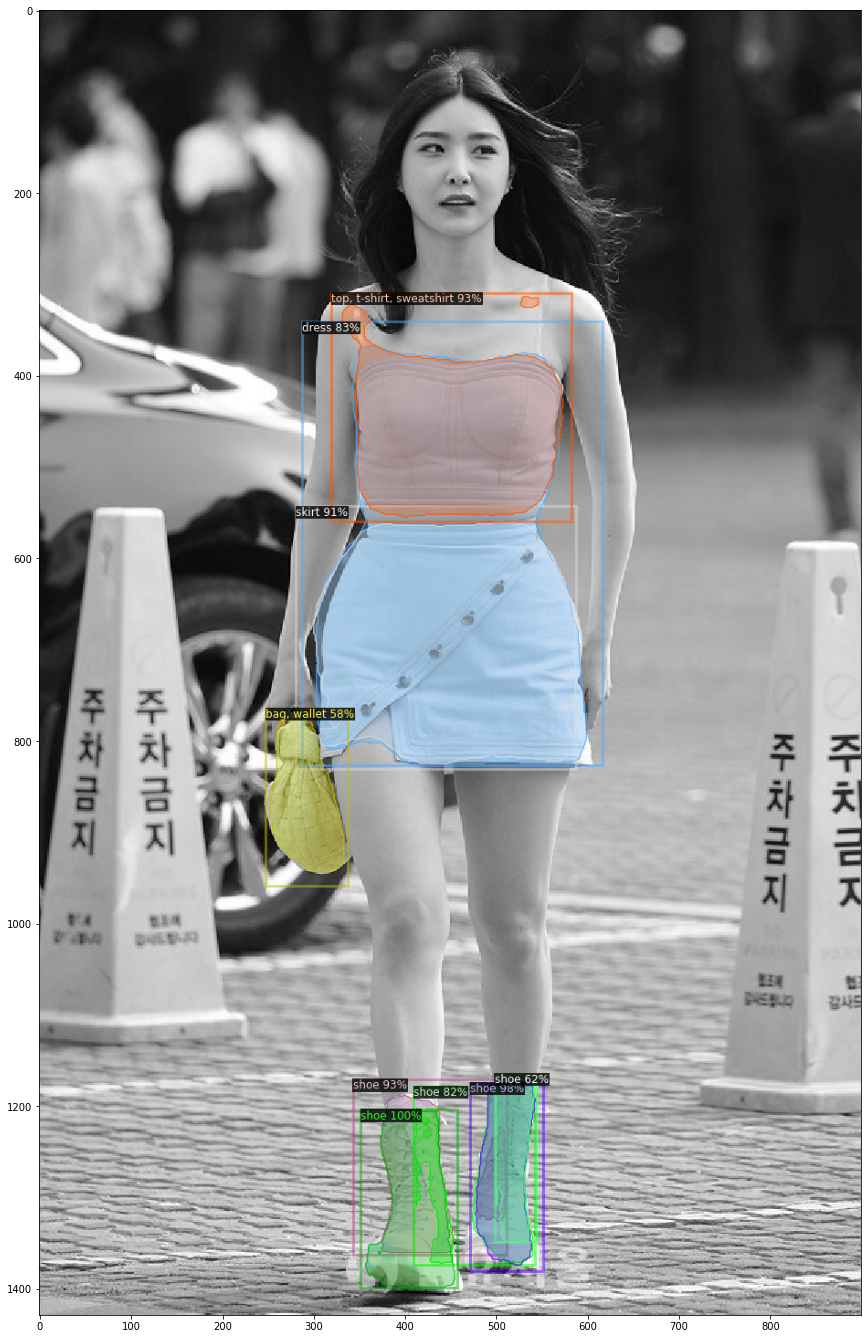

In [21]:
v = Visualizer(test_img[:, :, ::-1], metadata=fashion_metadata, scale=1.5, instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
ee = v.get_image()
plt.figure(figsize = (24,24))
plt.imshow(ee)

In [ ]:
import random

for d in testlist:

    img = cv.imread(d["file_name"])
    outputs = predictor(img)
    
    v = Visualizer(img[:, :, ::-1], metadata=fashion_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ee = v.get_image()
    plt.figure(figsize=(16,16))
    plt.imshow(ee)

In [ ]:
outputs

In [ ]:
type(predictor)

In [ ]:
mpath = "output/model_final_6ba57e.pkl"
mpath2 = "output/model_final.pth"

In [ ]:
import pickle

In [ ]:
mpath

In [ ]:
pretrained = ''

In [ ]:
with open("output/model_final_6ba57e.pkl", 'rb') as pickle_file:
    pretrained = pickle.load(pickle_file)

In [ ]:
type(pretrained)

In [ ]:
pretrained

In [ ]:
#### cfg.merge_from_file("fashionpedia_tools/config.yaml")

In [ ]:
v = v.draw_instance_predictions(out2["instances"].to("cpu"))

In [ ]:
model = nn.load(mpath2)

In [ ]:
import fashionpedia_tools

In [ ]:
from fashionpedia_tools import customized

In [ ]:
from fashionpedia_tools import data, solver

In [ ]:
from detectron2.config import LazyConfig as L

cfg = L.load("fashionpedia_tools/config.yaml")

In [ ]:
cfg

In [ ]:
cfg.MODEL.WEIGHTS = "output/model_final_6ba57e.pkl"

In [ ]:
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.config import instantiate

model = instantiate(cfg.model)
optimizer = instantiate(cfg.optimizer)

In [ ]:
from fashionpedia_tools import customized

In [ ]:


predictor = DefaultPredictor(cfg)


In [ ]:
import logging
from tabnanny import check
import torch
import gc
from detectron2.config import instantiate
from detectron2.utils import comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import (
    AMPTrainer,
    default_setup,
    default_writers,
    hooks)
from customized import EarlyStop, inference

def do_test(cfg, model):
    # Test function called by the EvalHook when current_iter = eval_period
    if "evaluator" in cfg.dataloader:
        ret = inference(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        return ret

In [ ]:
run fashionpedia_tools/main.py